<a href="https://colab.research.google.com/github/JulioLaz/store_sales_analysis_sqlite/blob/main/Store_Sales_Analysis_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

#**1. Configuración del Ambiente**


---




In [1]:
# !python -V
# print('------')
# !pip show Pandas | grep 'Name\|Version'
# print('------')
# !pip show Matplotlib | grep 'Name\|Version'

          # Python 3.10.12
          # ------
          # Name: pandas
          # Version: 2.0.3
          # ------
          # Name: matplotlib
          # Version: 3.7.1

In [2]:
!pip install geobr
import geobr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import requests
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, inspect, text
global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.3
    Uninstalling shapely-2.0.3:
      Successfully uninstalled shapely-2.0.3
  Attempting uninstall: lxml
    Found existing installation: lxml 4.9.4
    Uninstalling lxml-4.9.4:
      Successfully uninstalled lxml-4.9.4
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [4]:
df_itens_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
df_itens_pedidos.head()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [5]:
df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
df_pedidos.head()

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [6]:
df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
df_productos.head()

,producto_id,producto,precio,marca,sku,condicion
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297.0,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612.0,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482.0,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248.0,Usado


In [7]:
df_productos.producto.unique()

array(['Oculos Lente Azulada', 'Bolsa Coral Saco', 'Camisa Xadrez Verde',
       'Calca Alfaiataria Preta', 'Vestido Jeans Babados',
       'Mala Bolsos Preta', 'Casaco Preto Botoes', 'Calca Estampa Pb',
       'Shorts Jeans Destroyed', 'Camiseta Eternity',
       'Saia Amarela Faixa', 'Calca Textura Vermelha', 'Casaco La Mescla',
       'Blusinha Seda Off', 'Vestido Estampa Azul', 'Saia Midi Tricolor',
       'Sandalia Lona Cortica', 'Camisa Seda Pb', 'Blusinha Guipir Black',
       'Calca Verde Bolsos', 'Vestido Seda Floral', 'Saia Couro Tijolo',
       'Camiseta Animal Print', 'Blusa Pontas Blue',
       'Calca Alfaiataria Rose', 'Calca Estampa Flare',
       'Casaco Branco Costuras', 'Blusa Tricolor',
       'Vestido Couro Franjas', 'Vestido Estampa Bordado',
       'Blusa Malha Azul', 'Blusa Malha Paete', 'Vestido Estampa Laco',
       'Sandalia Nude Vazado', 'Sapatilha P&B Zebra',
       'Saia Transparente Cover', 'Saia Jeans Forest',
       'Calca Jeans Costuras', 'Bolsa Vermelh

In [8]:
# !pip install googletrans==4.0.0-rc1


In [9]:
# from googletrans import Translator
# import pandas as pd

# def traducir_texto(texto):
#     translator = Translator()
#     traduccion = translator.translate(texto, src='pt', dest='es')
#     return traduccion.text

# # Aplicar la traducción a la columna 'producto'
# df_productos['producto'] = df_productos['producto'].apply(traducir_texto)

# # Mostrar el DataFrame con los productos traducidos
# print(df_productos)


In [10]:
df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')
df_vendedores.head()

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


In [11]:
def info_df(dfs):
    for df in dfs:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print("Nombre del DataFrame:", df_name)
        print(df.info())
        print('-------------------------------------------')

# dfs = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]
# info_df(dfs)


In [12]:
dfs=[df_itens_pedidos,df_pedidos,df_productos,df_vendedores]
info_df(dfs)

Nombre del DataFrame: df_itens_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------------------------------------
Nombre del DataFrame: df_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 

##**2.2 Tratamiento de Datos**

In [13]:
df_productos[df_productos.producto.isna()]

,producto_id,producto,precio,marca,sku,condicion
205,41598,NaN,260,Banana Republic,NaN,Nuevo con etiqueta
206,32926,NaN,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


In [14]:
def preprocesamiento():
    global df_itens_pedidos, df_pedidos, df_productos, df_vendedores

    # Eliminar registros con valores nulos en columnas primary o foreign key
    df_itens_pedidos.dropna(subset=['pedido_id', 'producto_id'], inplace=True)
    df_pedidos.dropna(subset=['pedido_id', 'producto_id', 'vendedor_id'], inplace=True)
    df_productos.dropna(subset=['producto_id','producto'], inplace=True)###elimino tambien los nan de producto
    df_vendedores.dropna(subset=['vendedor_id'], inplace=True)

    #eliminar la fila con Unknown
    df_vendedores = df_vendedores[df_vendedores['nombre_vendedor'] != 'Unknown']

    # Eliminar registros duplicados
    df_itens_pedidos.drop_duplicates(inplace=True)
    df_pedidos.drop_duplicates(inplace=True)
    df_productos.drop_duplicates(inplace=True)
    df_vendedores.drop_duplicates(inplace=True)

    # Asegurar tipos de datos correctos:
    df_itens_pedidos['id_recibo'] = df_itens_pedidos['id_recibo'].astype(int)
    df_itens_pedidos['producto_id'] = df_itens_pedidos['producto_id'].astype(int)
    df_itens_pedidos['pedido_id'] = df_itens_pedidos['pedido_id'].astype(int)
    df_itens_pedidos['ciudad'] = df_itens_pedidos['ciudad'].astype(str)
    df_itens_pedidos['costo_envio'] = df_itens_pedidos['costo_envio'].astype(float)

    df_pedidos['pedido_id'] = df_pedidos['pedido_id'].astype(int)
    df_pedidos['producto_id'] = df_pedidos['producto_id'].astype(int)
    df_pedidos['vendedor_id'] = df_pedidos['vendedor_id'].astype(int)
    df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'])

    df_productos['producto_id'] = df_productos['producto_id'].astype(int)
    df_productos['precio'] = df_productos['precio'].astype(float)
    df_productos['sku'] = df_productos['sku'].astype(str)

    df_vendedores['vendedor_id'] = df_vendedores['vendedor_id'].astype(int)
    df_vendedores['nombre_vendedor'] = df_vendedores['nombre_vendedor'].astype(str)

    return df_itens_pedidos, df_pedidos, df_productos, df_vendedores

df_itens_pedidos, df_pedidos, df_productos, df_vendedores = preprocesamiento()

<ipython-input-14-33b9c90aa8fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendedores.drop_duplicates(inplace=True)
<ipython-input-14-33b9c90aa8fa>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendedores['vendedor_id'] = df_vendedores['vendedor_id'].astype(int)
<ipython-input-14-33b9c90aa8fa>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [15]:
df_vendedores

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


In [16]:
dfs=[df_itens_pedidos,df_pedidos,df_productos,df_vendedores]
info_df(dfs)

Nombre del DataFrame: df_itens_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------------------------------------
Nombre del DataFrame: df_pedidos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24527 non-null  int64         
 

##**2.3 Análisis Exploratorio (EDA)**

In [17]:
def describe_dfs_all(dfs):
  for df in dfs:
    df_name = [name for name, obj in globals().items() if obj is df][0]
    print("Nombre del DataFrame:", df_name)
    print(df.describe().round(1))
    print('--------------------------------------------------------------------------------------')

In [18]:
dfs = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]
describe_dfs_all(dfs)

Nombre del DataFrame: df_itens_pedidos
       id_recibo  producto_id  pedido_id  cantidad  valor_unitario  \
count    24527.0      24527.0    24527.0   24527.0         24527.0   
mean     12405.4      44627.6    69931.4       3.5           535.7   
std       7242.7      29347.8    40560.8       1.7           839.2   
min          1.0       2706.0        1.0       1.0            45.0   
25%       6132.5      17258.0    34487.0       2.0           210.0   
50%      12264.0      42913.0    69945.0       4.0           336.0   
75%      18689.5      70673.0   105355.0       5.0           450.0   
max      25055.0     100983.0   139993.0       6.0          6500.0   

       valor_total  costo_envio  
count      24527.0      24527.0  
mean        1867.5        373.5  
std         3379.7        675.9  
min           45.0          9.0  
25%          520.0        104.0  
50%         1050.0        210.0  
75%         1920.0        384.0  
max        39000.0       7800.0  
------------------------

In [19]:
def describe_dfs(dfs):
    for df in dfs:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print("Nombre del DataFrame:", df_name)
        non_id_columns = [col for col in df.columns if 'id' not in col.lower()]
        if non_id_columns:
            print(df[non_id_columns].describe().round(1))
        else:
            print("No hay columnas para describir, todas son identificadores.")
        print('-------------------------------------------')

In [20]:
dfs = [df_itens_pedidos, df_pedidos, df_productos, df_vendedores]
describe_dfs(dfs)

Nombre del DataFrame: df_itens_pedidos
       valor_unitario  valor_total  costo_envio
count         24527.0      24527.0      24527.0
mean            535.7       1867.5        373.5
std             839.2       3379.7        675.9
min              45.0         45.0          9.0
25%             210.0        520.0        104.0
50%             336.0       1050.0        210.0
75%             450.0       1920.0        384.0
max            6500.0      39000.0       7800.0
-------------------------------------------
Nombre del DataFrame: df_pedidos
                        fecha_compra    total
count                          24527  24527.0
mean   2020-04-02 12:10:46.406001664   1867.5
min              2019-01-05 00:00:00     45.0
25%              2019-11-12 00:00:00    520.0
50%              2020-04-09 00:00:00   1050.0
75%              2020-09-21 00:00:00   1920.0
max              2021-03-10 00:00:00  39000.0
std                              NaN   3379.7
--------------------------------------

In [21]:
df_pedidos.sample(5)

,pedido_id,producto_id,vendedor_id,fecha_compra,total
5261,133854,35682,3,2019-10-11,750
23332,132835,9397,3,2021-01-20,1725
22403,101200,33976,4,2020-12-25,360
24377,95039,87711,3,2021-02-17,280
4999,89833,31651,1,2019-10-03,180


In [22]:
df_pedidos.describe().round(1)

,pedido_id,producto_id,vendedor_id,fecha_compra,total
count,24527.0,24527.0,24527.0,24527,24527.0
mean,69931.4,44627.6,3.0,2020-04-02 12:10:46.406001664,1867.5
min,1.0,2706.0,1.0,2019-01-05 00:00:00,45.0
25%,34487.0,17258.0,2.0,2019-11-12 00:00:00,520.0
50%,69945.0,42913.0,3.0,2020-04-09 00:00:00,1050.0
75%,105355.0,70673.0,4.0,2020-09-21 00:00:00,1920.0
max,139993.0,100983.0,6.0,2021-03-10 00:00:00,39000.0
std,40560.8,29347.8,1.4,NaN,3379.7


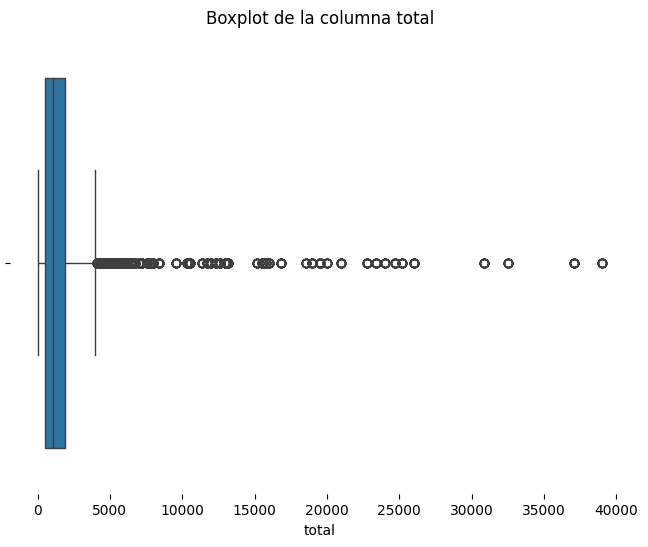

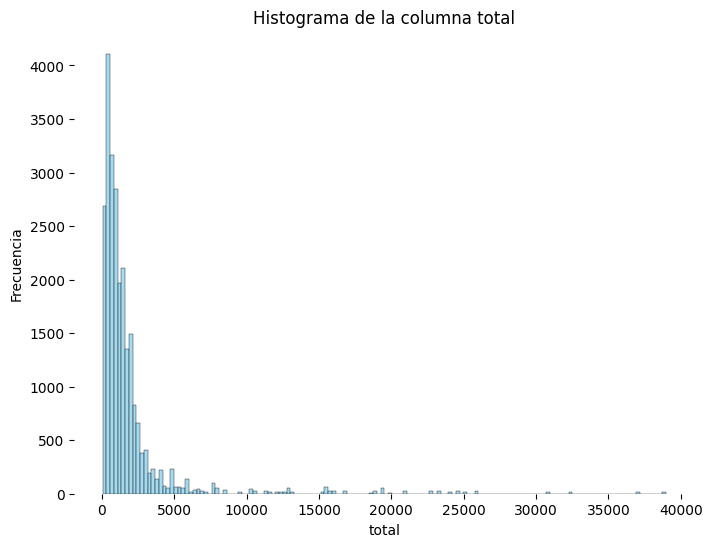

In [23]:
def Boxplot_Histograma_graf(df,col):
  plt.figure(figsize=(8, 6))
  sns.boxplot(data=df, x=col)
  plt.title(f'Boxplot de la columna {col}')
  plt.xlabel(col)
  plt.ylabel('')
  plt.box(None)
  plt.show()
  plt.figure(figsize=(8, 6))
  sns.histplot(data=df, x=col, bins=150, color='skyblue', edgecolor='black')
  plt.title(f'Histograma de la columna {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.box(None)
  plt.show()
Boxplot_Histograma_graf(df_pedidos,'total')

In [24]:
df_productos.describe()

,producto_id,precio
count,205.000000,205.000000
mean,44803.365854,536.009756
std,29419.632374,843.774387
min,2706.000000,45.000000
25%,17329.000000,210.000000
50%,43054.000000,336.000000
75%,70673.000000,450.000000
max,100983.000000,6500.000000


In [25]:
df_productos.sample(5)

,producto_id,producto,precio,marca,sku,condicion
143,14420,Vestido Rose Drapeado,690.0,Vera Wang,295452.0,Nuevo sin etiqueta
142,53941,Cropped Escritas Pb,280.0,Linda de Morrer,917972.0,Usado
5,51238,Mala Bolsos Preta,410.0,Gap,286008.0,Usado
10,46573,Saia Amarela Faixa,350.0,Banana Republic,291820.0,Usado
7,44207,Calca Estampa Pb,290.0,Fyi,294021.0,Usado


In [26]:
df_productos.marca.unique()

array(['D&g Dolce & Gabbana', 'Givenchy', 'Joe Fresh', 'Mixed', 'Zara',
       'Gap', 'Banana Republic', 'Fyi', 'Sacada', 'Rag & Bone', 'Cori',
       'Forever 21', 'Tigresse', 'Tory Burch', 'Brooksfield', 'Animale',
       '284', 'Dkny', 'Cheroy', 'Canal', 'Le Lis Blanc', 'Spezzato',
       'Cantão', 'Talie Nk', 'H&M', 'Schutz', 'Jorge Bischoff',
       'Luisa Farani', 'Seven', 'Kipling', 'Louis Vuitton', 'Agilità',
       'Fabiana Caterina', 'Reinaldo Lourenço', 'Karmani', 'Erre Erre',
       'H&m', 'Forum', 'Ellus', 'J. Crew', "Joe's", 'Galeria Tricot',
       'Loft 747', 'Oxyfit', 'Topshop', 'A.brand', 'Isolda',
       'American Eagle', 'Colcci', 'Carter’s', 'Thay Ribas',
       'Carina Duek', 'Kate Spade', 'Bottega Veneta', 'Morena Rosa',
       'Luiza Barcelos', 'Lezalez', 'My Place', 'Farm', 'Armani Exchange',
       'Bcbgmaxzria', 'Dica da Ka', 'My Shoes', 'Argentum',
       'Red Valentino', 'Maria Filó', 'Marc By Marcjacobs',
       'Track & Field', 'Christian Dior', 'Toca do 

In [27]:
len(df_productos.marca.unique())

117

In [28]:
df_productos.condicion.value_counts()

condicion
Usado                 176
Nuevo con etiqueta     22
Nuevo sin etiqueta      7
Name: count, dtype: int64

In [29]:
# Calcular la frecuencia de cada marca
marca_counts = df_productos['marca'].value_counts()

# Filtrar las marcas con frecuencia mayor que 1
marca_counts_gt1 = marca_counts[marca_counts > 1]

# Mostrar las marcas con frecuencia mayor que 1
print(marca_counts_gt1)


marca
Zara               23
Mixed              14
Animale             9
Le Lis Blanc        6
Banana Republic     5
Farm                4
H&m                 4
Forever 21          3
Forum               3
Dress&co            3
Tigresse            3
Sacada              3
Shoulder            3
Hollister           2
Schutz              2
Colcci              2
A.brand             2
Bazar Genial        2
Ellus               2
Ralph Lauren        2
Maria Bonita        2
Thelure             2
Levi's              2
Seven               2
Jorge Bischoff      2
Christian Dior      2
Fyi                 2
Cantão              2
Cori                2
Spezzato            2
Tory Burch          2
Name: count, dtype: int64


In [30]:
# Agrupar por marca y sumar los precios
agrupado_por_marca = df_productos.groupby('marca')['precio'].sum()
df_agrupado_por_marca = agrupado_por_marca.to_frame()

df_agrupado_por_marca.reset_index(drop=False, inplace=True)
df_agrupado_por_marca_ordenado = df_agrupado_por_marca.sort_values(by='precio', ascending=False)

df_agrupado_por_marca_ordenado.rename(columns={'precio':'suma_precio'},inplace=True)
df_agrupado_por_marca_ordenado

,marca,suma_precio
85,Mixed,10811.0
27,Christian Dior,7250.0
17,Bottega Veneta,6175.0
13,Barbara Bela,4200.0
51,Givenchy,4000.0
...,...,...
43,Fabiana Caterina,120.0
114,Track & Field,120.0
111,Toca do Coelho,110.0
57,Isa Kulikovski,90.0


In [31]:
df_productos[df_productos.marca=='Mixed']

,producto_id,producto,precio,marca,sku,condicion
3,47475,Calca Alfaiataria Preta,490.0,Mixed,263658.0,Usado
9,6262,Camiseta Eternity,644.0,Mixed,247015.0,Nuevo con etiqueta
17,31835,Camisa Seda Pb,399.0,Mixed,258114.0,Usado
21,17990,Saia Couro Tijolo,3800.0,Mixed,255109.0,Usado
37,5292,Saia Jeans Forest,576.0,Mixed,222683.0,Nuevo con etiqueta
68,11736,Saia Guipir Nude,740.0,Mixed,324428.0,Usado
79,6381,Camiseta Cindy Sky,586.0,Mixed,193567.0,Nuevo con etiqueta
83,68110,Casaqueto Fio Mescla,790.0,Mixed,294836.0,Usado
110,6137,Camisa Tear Folk,100.0,Mixed,114671.0,Nuevo con etiqueta
115,5995,Calca Linho Ten,398.0,Mixed,216052.0,Nuevo con etiqueta


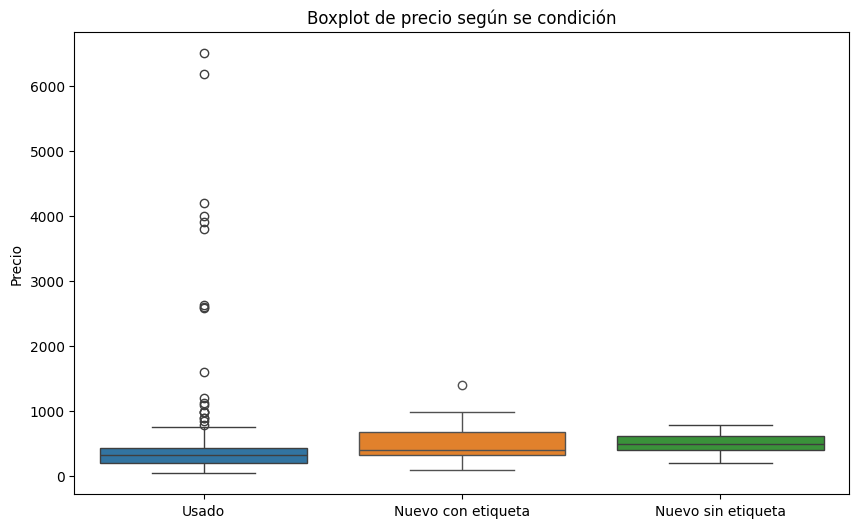

In [32]:
# Filtrar el DataFrame para cada condición
df_usado = df_productos[df_productos['condicion'] == 'Usado']
df_nuevo = df_productos[df_productos['condicion'] == 'Nuevo con etiqueta']
df_etiqueta = df_productos[df_productos['condicion'] == 'Nuevo sin etiqueta']

# Crear los boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_usado, x='condicion', y='precio', order=['Usado', 'Nuevo con etiqueta', 'Nuevo sin etiqueta'])
sns.boxplot(data=df_nuevo, x='condicion', y='precio', order=['Usado', 'Nuevo con etiqueta', 'Nuevo sin etiqueta'])
sns.boxplot(data=df_etiqueta, x='condicion', y='precio', order=['Usado', 'Nuevo con etiqueta', 'Nuevo sin etiqueta'])
plt.title('Boxplot de precio según se condición')
plt.xlabel('')
plt.ylabel('Precio')
plt.show()

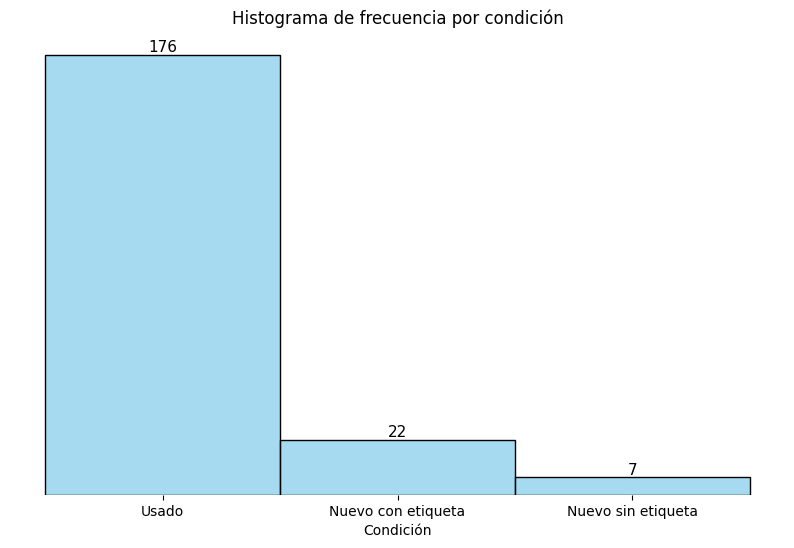

In [33]:
# Crear el histograma de frecuencia vs condición
plt.figure(figsize=(10, 6))
sns.histplot(data=df_productos, x='condicion', stat='count', discrete=True, color='skyblue', edgecolor='black')
plt.title('Histograma de frecuencia por condición')
plt.xlabel('Condición')
plt.ylabel('')
plt.yticks([])
plt.box(None)
# Agregar el valor al final de cada barra
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()


In [34]:
df_itens_pedidos.describe()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,costo_envio
count,24527.000000,24527.000000,24527.000000,24527.000000,24527.00000,24527.000000,24527.000000
mean,12405.414278,44627.641171,69931.383088,3.497126,535.68867,1867.490113,373.498023
std,7242.697484,29347.824879,40560.769565,1.706170,839.21405,3379.681887,675.936377
min,1.000000,2706.000000,1.000000,1.000000,45.00000,45.000000,9.000000
25%,6132.500000,17258.000000,34487.000000,2.000000,210.00000,520.000000,104.000000
50%,12264.000000,42913.000000,69945.000000,4.000000,336.00000,1050.000000,210.000000
75%,18689.500000,70673.000000,105355.000000,5.000000,450.00000,1920.000000,384.000000
max,25055.000000,100983.000000,139993.000000,6.000000,6500.00000,39000.000000,7800.000000


In [35]:
df_itens_pedidos.sample(5)

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
7311,7312,33976,82484,1,120,120,BR-BA,24.0
1722,1723,17329,103528,2,590,1180,BR-PR,236.0
4508,4509,29650,72803,1,120,120,BR-GO,24.0
5401,5402,33349,81265,3,270,810,BR-SP,162.0
4191,4192,12812,4365,1,320,320,BR-SE,64.0


In [36]:
df_itens_pedidos_sorted=df_itens_pedidos.sort_values(by='valor_total',ascending=False)
df_itens_pedidos_sorted[df_itens_pedidos_sorted.valor_total>38000]

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
1275,1276,3865,89739,6,6500,39000,BR-SP,7800.0
2951,2952,3865,48161,6,6500,39000,BR-PR,7800.0
23317,23812,3865,126192,6,6500,39000,BR-DF,7800.0
10659,10660,3865,132843,6,6500,39000,BR-PI,7800.0
1387,1388,3865,25055,6,6500,39000,BR-RR,7800.0
22778,23273,3865,68412,6,6500,39000,BR-PE,7800.0
21546,21984,3865,84524,6,6500,39000,BR-SE,7800.0
8405,8406,3865,119135,6,6500,39000,BR-CE,7800.0
19945,20240,3865,37549,6,6500,39000,BR-AP,7800.0
20646,20959,3865,95881,6,6500,39000,BR-RO,7800.0


In [37]:
# Unir df_itens_pedidos con df_pedidos
df_merged = pd.merge(df_itens_pedidos, df_productos, on='producto_id', how='inner')
df_merged


,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio,producto,precio,marca,sku,condicion
0,1,41518,341,3,260,780,BR-BA,156.0,Calca Jeans Basica,260.0,Banana Republic,255410.0,Nuevo con etiqueta
1,489,41518,15598,3,260,780,BR-AP,156.0,Calca Jeans Basica,260.0,Banana Republic,255410.0,Nuevo con etiqueta
2,734,41518,28333,2,260,520,BR-MG,104.0,Calca Jeans Basica,260.0,Banana Republic,255410.0,Nuevo con etiqueta
3,792,41518,64689,5,260,1300,BR-DF,260.0,Calca Jeans Basica,260.0,Banana Republic,255410.0,Nuevo con etiqueta
4,932,41518,10711,5,260,1300,BR-SC,260.0,Calca Jeans Basica,260.0,Banana Republic,255410.0,Nuevo con etiqueta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24522,24048,29301,133955,6,180,1080,BR-SC,216.0,Blusa Renda Off,180.0,Espaço Fashion,307359.0,Usado
24523,24091,29301,22125,1,180,180,BR-RR,36.0,Blusa Renda Off,180.0,Espaço Fashion,307359.0,Usado
24524,24310,29301,19830,5,180,900,BR-SE,180.0,Blusa Renda Off,180.0,Espaço Fashion,307359.0,Usado
24525,24470,29301,114271,6,180,1080,BR-BA,216.0,Blusa Renda Off,180.0,Espaço Fashion,307359.0,Usado


In [38]:
df_merged_sorted=df_merged.sort_values(by='valor_total',ascending=False)
df_merged_sorted[df_merged_sorted.valor_unitario>6200]
# df_merged_sorted[df_merged_sorted.valor_total>38000]

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio,producto,precio,marca,sku,condicion
23708,23273,3865,68412,6,6500,39000,BR-PE,7800.0,Bolsa Classica Roxa,6500.0,Christian Dior,165834.0,Usado
23665,15975,3865,40446,6,6500,39000,BR-PI,7800.0,Bolsa Classica Roxa,6500.0,Christian Dior,165834.0,Usado
23594,1276,3865,89739,6,6500,39000,BR-SP,7800.0,Bolsa Classica Roxa,6500.0,Christian Dior,165834.0,Usado
23607,2952,3865,48161,6,6500,39000,BR-PR,7800.0,Bolsa Classica Roxa,6500.0,Christian Dior,165834.0,Usado
23608,3490,3865,119168,6,6500,39000,BR-MT,7800.0,Bolsa Classica Roxa,6500.0,Christian Dior,165834.0,Usado
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23700,22284,3865,132207,1,6500,6500,BR-PA,1300.0,Bolsa Classica Roxa,6500.0,Christian Dior,165834.0,Usado
23694,21876,3865,4952,1,6500,6500,BR-SP,1300.0,Bolsa Classica Roxa,6500.0,Christian Dior,165834.0,Usado
23602,1914,3865,74051,1,6500,6500,BR-AM,1300.0,Bolsa Classica Roxa,6500.0,Christian Dior,165834.0,Usado
23660,13795,3865,32804,1,6500,6500,BR-AL,1300.0,Bolsa Classica Roxa,6500.0,Christian Dior,165834.0,Usado


In [39]:
df_merged_sorted_count=df_merged.sort_values(by='cantidad',ascending=False)
df_merged_sorted_count['ganancia_neta']=(df_merged_sorted_count['valor_total']-df_merged_sorted_count['costo_envio']).astype(int)
df_merged_sorted_count

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio,producto,precio,marca,sku,condicion,ganancia_neta
19297,21001,97039,128307,6,320,1920,BR-DF,384.0,Calca Jeans Ilhos,320.0,Colcci,947042.0,Usado,1536
15687,5050,73038,130584,6,90,540,BR-ES,108.0,Blusa Veludo Flores,90.0,Isa Kulikovski,248238.0,Usado,432
5008,19099,83795,113150,6,310,1860,BR-MA,372.0,Vestido Estampa Color,310.0,Cantão,309928.0,Usado,1488
15746,16210,73038,70909,6,90,540,BR-PE,108.0,Blusa Veludo Flores,90.0,Isa Kulikovski,248238.0,Usado,432
20823,19858,88368,61653,6,250,1500,BR-MT,300.0,Blusa Malha Azul,250.0,Talie Nk,254726.0,Usado,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7252,4799,80644,109844,1,990,990,BR-PR,198.0,Bolsa Azul Candy,990.0,Lauren Ralph Lauren,289991.0,Usado,792
7253,4979,80644,75915,1,990,990,BR-AP,198.0,Bolsa Azul Candy,990.0,Lauren Ralph Lauren,289991.0,Usado,792
19097,6134,12812,2619,1,320,320,BR-AC,64.0,Sandalia Nude Vazado,320.0,Schutz,522917.0,Usado,256
19095,5738,12812,27007,1,320,320,BR-SE,64.0,Sandalia Nude Vazado,320.0,Schutz,522917.0,Usado,256


###Top 10 marca:

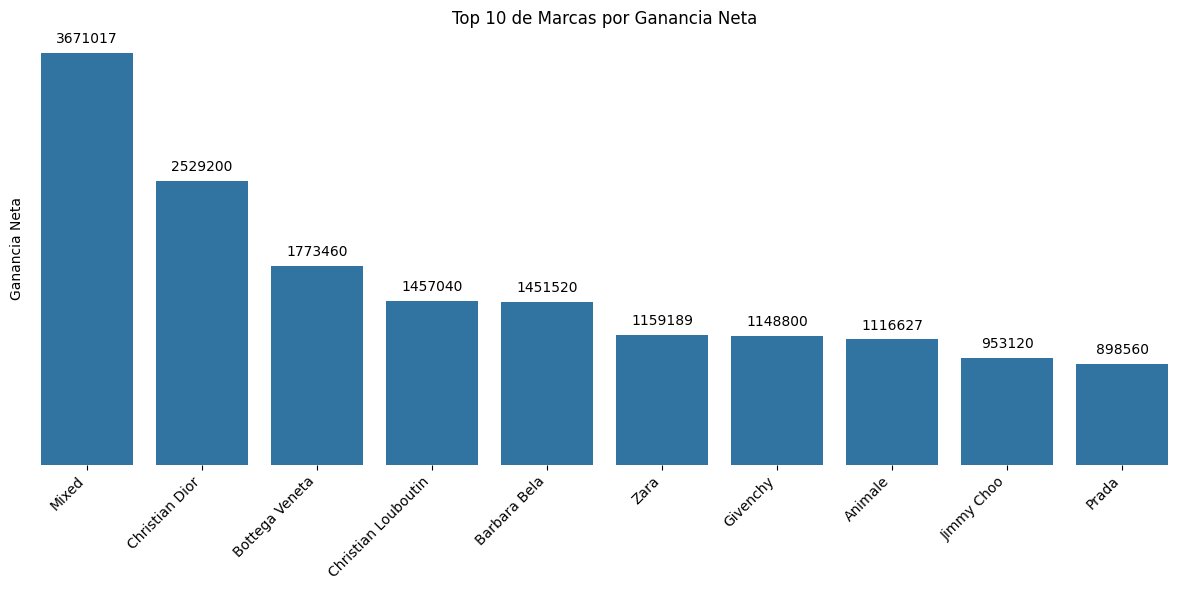

In [40]:
df=df_merged_sorted_count.copy()
top_10_marcas = df.groupby('marca')['ganancia_neta'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_10_marcas.index, y=top_10_marcas.values)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.title('Top 10 de Marcas por Ganancia Neta')
plt.xlabel('')
plt.ylabel('Ganancia Neta')
plt.xticks(rotation=45, ha='right')
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.show()

###Top 10 productos:

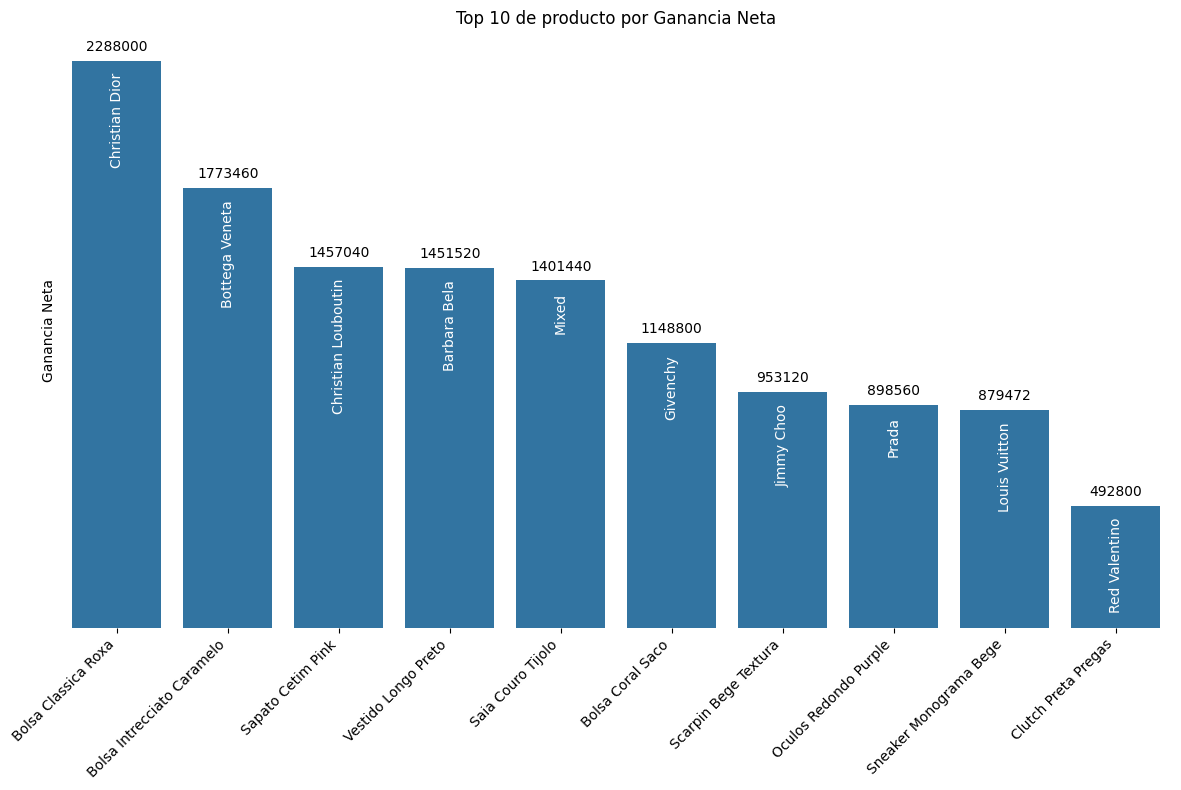

In [41]:
top_10_producto_con_marca = df.groupby(['producto', 'marca'])['ganancia_neta'].sum().nlargest(10)

df_ver=pd.DataFrame(top_10_producto_con_marca)
df_ver.reset_index(drop=False,inplace=True)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=df_ver['producto'], y=df_ver['ganancia_neta'])

# Agregar etiquetas con el nombre de la marca al inicio de cada barra
for index, row in df_ver.iterrows():
    ax.text(row.name, row['ganancia_neta']-.5e5, row['marca'],
            color='white', ha="center", va='top', rotation=90)

# Agregar valores al final de las barras
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# Configurar título y etiquetas
plt.title('Top 10 de producto por Ganancia Neta')
plt.xlabel('')
plt.ylabel('Ganancia Neta')
plt.xticks(rotation=45, ha='right')
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.show()


In [42]:
# Agrupar por producto y encontrar el precio máximo
productos_mayor_precio = df_productos.groupby('producto')['precio'].max()

df_productos_mayor_precio=pd.DataFrame(productos_mayor_precio)
df_productos_mayor_precio.reset_index(inplace=True)
df_productos_mayor_precio.sort_values(by='precio',ascending=False).head(10)

,producto,precio
40,Bolsa Classica Roxa,6500.0
42,Bolsa Intrecciato Caramelo,6175.0
178,Vestido Longo Preto,4200.0
41,Bolsa Coral Saco,4000.0
142,Sapato Cetim Pink,3900.0
120,Saia Couro Tijolo,3800.0
154,Sneaker Monograma Bege,2630.0
108,Oculos Redondo Purple,2600.0
144,Scarpin Bege Textura,2590.0
94,Clutch Preta Pregas,1600.0


In [43]:
df_itens_pedidos.describe()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,costo_envio
count,24527.000000,24527.000000,24527.000000,24527.000000,24527.00000,24527.000000,24527.000000
mean,12405.414278,44627.641171,69931.383088,3.497126,535.68867,1867.490113,373.498023
std,7242.697484,29347.824879,40560.769565,1.706170,839.21405,3379.681887,675.936377
min,1.000000,2706.000000,1.000000,1.000000,45.00000,45.000000,9.000000
25%,6132.500000,17258.000000,34487.000000,2.000000,210.00000,520.000000,104.000000
50%,12264.000000,42913.000000,69945.000000,4.000000,336.00000,1050.000000,210.000000
75%,18689.500000,70673.000000,105355.000000,5.000000,450.00000,1920.000000,384.000000
max,25055.000000,100983.000000,139993.000000,6.000000,6500.00000,39000.000000,7800.000000


In [44]:
df_itens_pedidos.sample(5)

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
19085,19380,100983,16940,6,350,2100,BR-AL,420.0
11084,11085,5567,9633,5,210,1050,BR-PB,210.0
2822,2823,21429,106346,5,390,1950,BR-MG,390.0
10634,10635,47682,113087,5,430,2150,BR-TO,430.0
1784,1785,67445,138390,5,320,1600,BR-SE,320.0


In [45]:
df_itens_pedidos['ganancia_neta']=(df_itens_pedidos['valor_total']-df_itens_pedidos['costo_envio']).astype(int)
df_itens_pedidos


,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio,ganancia_neta
0,1,41518,341,3,260,780,BR-BA,156.0,624
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0,24700
2,3,22407,1399,3,200,600,BR-PB,120.0,480
3,4,3820,1652,6,139,834,BR-DF,166.8,667
4,5,29012,2470,3,525,1575,BR-BA,315.0,1260
...,...,...,...,...,...,...,...,...,...
24522,25051,64127,63716,4,590,2360,BR-PE,472.0,1888
24523,25052,37384,63999,4,700,2800,BR-RO,560.0,2240
24524,25053,100932,64594,5,3900,19500,BR-RO,3900.0,15600
24525,25054,3820,64811,3,139,417,BR-MA,83.4,333


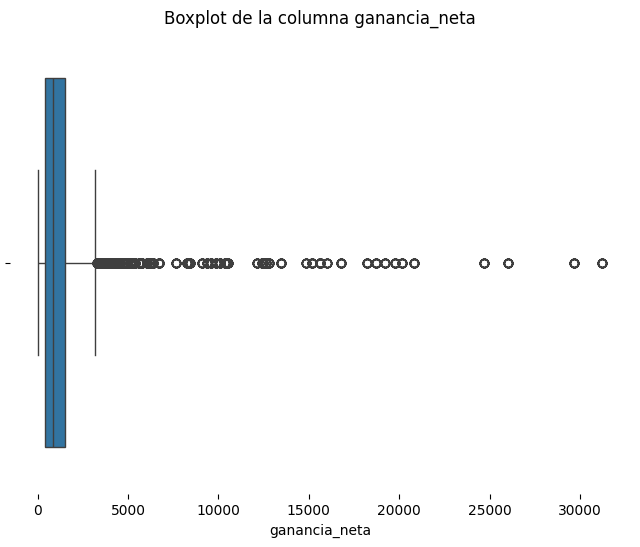

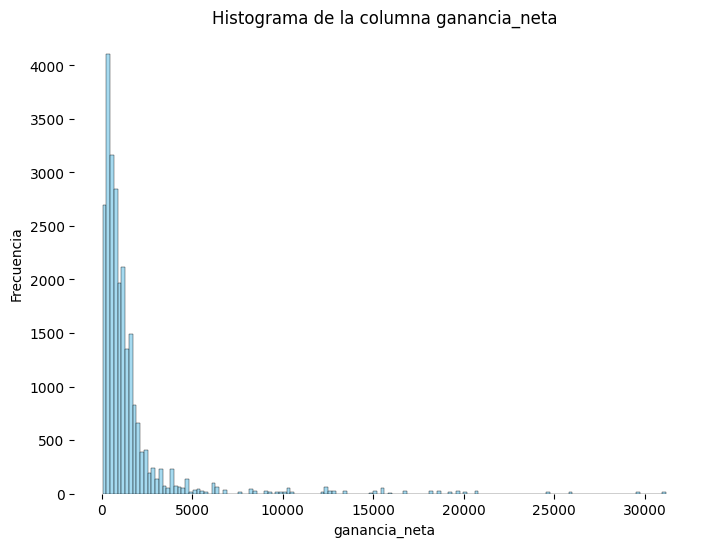

In [46]:
Boxplot_Histograma_graf(df_itens_pedidos,'ganancia_neta')

In [47]:
df=df_itens_pedidos.copy()
top_ciudad = df.groupby('ciudad')['ganancia_neta'].sum()
# top_10_ciudad = df.groupby('ciudad')['ganancia_neta'].sum().nlargest(50)
df_ciudades_ganancias_netas=pd.DataFrame(top_ciudad)
df_ciudades_ganancias_netas.reset_index(inplace=True)
df_ciudades_ganancias_netas['cod_ciudad_brasil']= [ciudad.replace('BR-', '') for ciudad in df_ciudades_ganancias_netas.ciudad]
df_ciudades_ganancias_netas.drop(columns='ciudad',axis=1,inplace=True)
df_ciudades_ganancias_netas

,ganancia_neta,cod_ciudad_brasil
0,1128495,AC
1,1521989,AL
2,1244061,AM
3,1475708,AP
4,1322488,BA
5,1468041,CE
6,1327068,DF
7,1275849,ES
8,1418180,GO
9,1453022,MA


In [48]:
# Diccionario de correspondencias entre siglas y nombres de ciudades
ciudades = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AM': 'Amazonas',
    'AP': 'Amapá',
    'BA': 'Bahía',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MG': 'Minas Gerais',
    'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'PR': 'Paraná',
    'RJ': 'Río de Janeiro',
    'RN': 'Río Grande del Norte',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'RS': 'Río Grande del Sur',
    'SC': 'Santa Catarina',
    'SE': 'Sergipe',
    'SP': 'São Paulo',
    'TO': 'Tocantins'
}

# Reemplazar las siglas por los nombres de las ciudades en el dataframe
df_ciudades_ganancias_netas['ciudad'] = df_ciudades_ganancias_netas['cod_ciudad_brasil'].map(ciudades)
df_ciudades_ganancias_netas=df_ciudades_ganancias_netas[['cod_ciudad_brasil','ciudad','ganancia_neta']]
df_ciudades_ganancias_netas

,cod_ciudad_brasil,ciudad,ganancia_neta
0,AC,Acre,1128495
1,AL,Alagoas,1521989
2,AM,Amazonas,1244061
3,AP,Amapá,1475708
4,BA,Bahía,1322488
5,CE,Ceará,1468041
6,DF,Distrito Federal,1327068
7,ES,Espírito Santo,1275849
8,GO,Goiás,1418180
9,MA,Maranhão,1453022


In [49]:
import geopandas as gpd
import geobr
df=df_ciudades_ganancias_netas

br_uf = geobr.read_state()
br_uf = br_uf.rename(columns={'abbrev_state': 'cod_ciudad_brasil'})
br_uf_d = br_uf.merge(df, on='cod_ciudad_brasil')
br_uf_d = br_uf_d[['geometry','cod_ciudad_brasil', 'ganancia_neta']]
br_uf_d.head()

,geometry,cod_ciudad_brasil,ganancia_neta
0,"MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...",RO,1317470
1,"MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...",AC,1128495
2,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...",AM,1244061
3,"MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...",RR,1349741
4,"MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...",PA,1345172


<ipython-input-50-3f5e59bc288e>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.cod_ciudad_brasil):
<ipython-input-50-3f5e59bc288e>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.cod_ciudad_brasil):


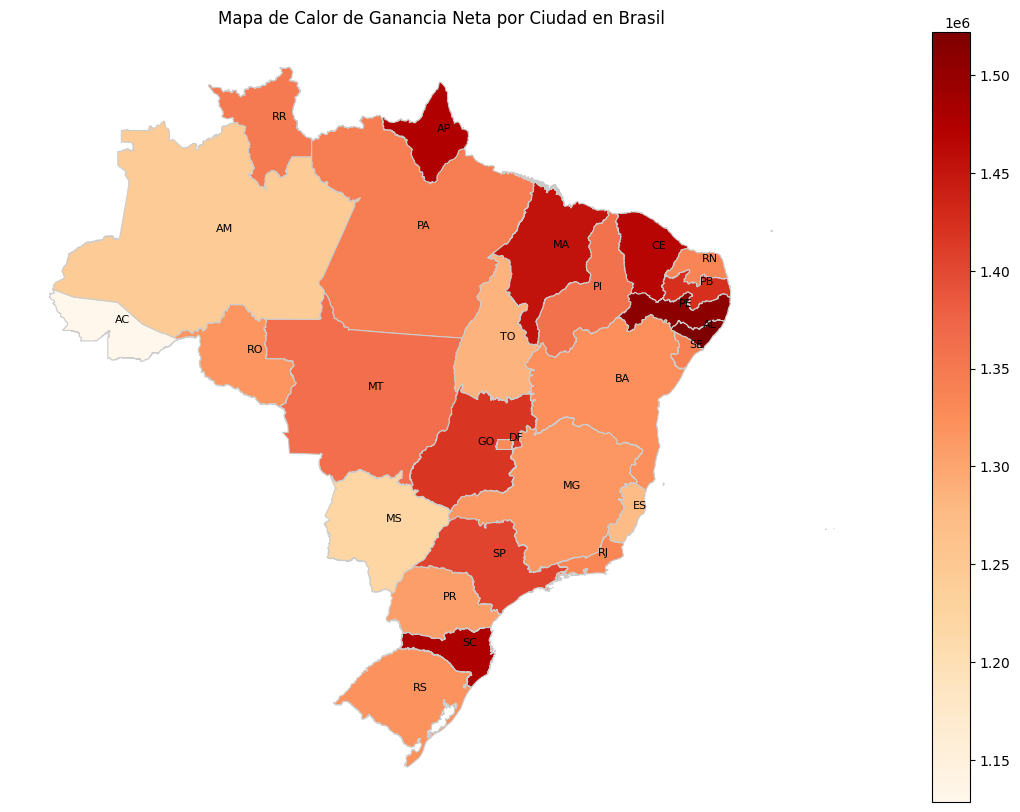

In [50]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Crear el mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
br_uf_d.plot(column='ganancia_neta', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Agregar el nombre de la ciudad en cada lugar
for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.cod_ciudad_brasil):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='black')

plt.title('Mapa de Calor de Ganancia Neta por Ciudad en Brasil')
plt.axis('off')
plt.show()


<ipython-input-51-032a1f163e05>:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.ciudad):
<ipython-input-51-032a1f163e05>:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.ciudad):


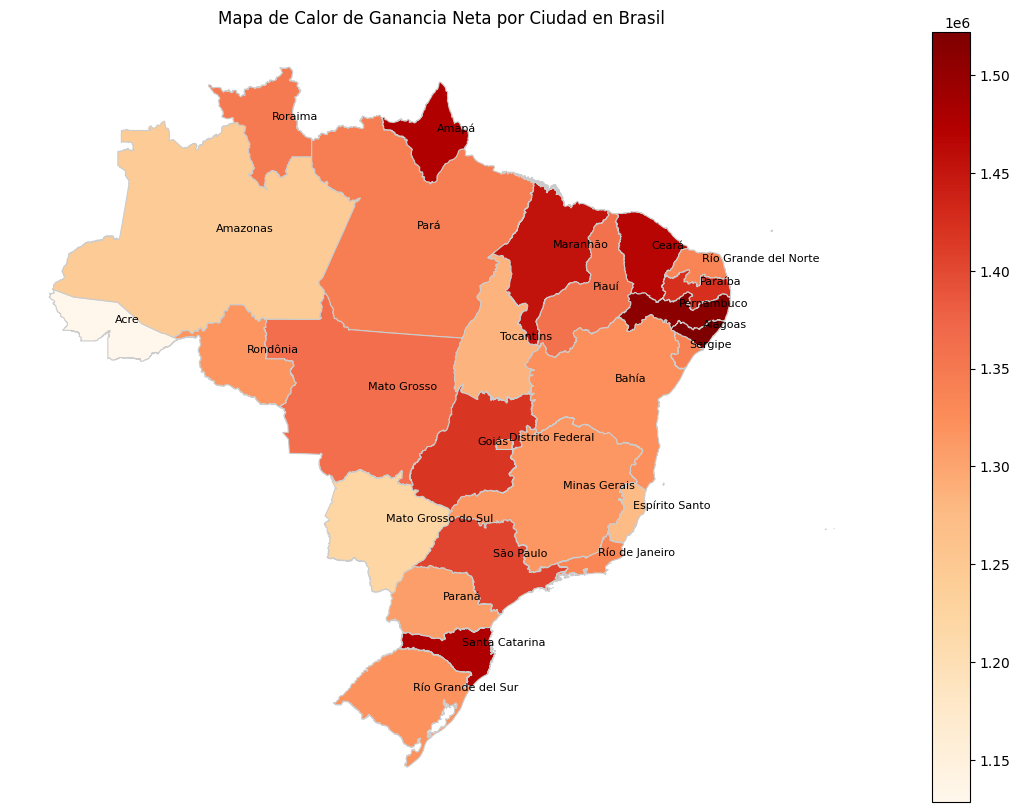

In [51]:
# Diccionario de correspondencias entre siglas y nombres de ciudades
ciudades = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AM': 'Amazonas',
    'AP': 'Amapá',
    'BA': 'Bahía',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MG': 'Minas Gerais',
    'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'PR': 'Paraná',
    'RJ': 'Río de Janeiro',
    'RN': 'Río Grande del Norte',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'RS': 'Río Grande del Sur',
    'SC': 'Santa Catarina',
    'SE': 'Sergipe',
    'SP': 'São Paulo',
    'TO': 'Tocantins'
}

# Reemplazar las siglas por los nombres de las ciudades en el dataframe
br_uf_d['ciudad'] = br_uf_d['cod_ciudad_brasil'].map(ciudades)

# Crear el mapa de calor con los nombres de las ciudades
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
br_uf_d.plot(column='ganancia_neta', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Agregar el nombre de la ciudad en cada lugar
for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.ciudad):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='black')

plt.title('Mapa de Calor de Ganancia Neta por Ciudad en Brasil')
plt.axis('off')
plt.show()


In [52]:
df=df_itens_pedidos.copy()
top_10_ciudad = df.groupby('ciudad')['ganancia_neta'].sum().nlargest(10)
df_top_10_ciudad=pd.DataFrame(top_10_ciudad)
df_top_10_ciudad.reset_index(drop=False,inplace=True)
df_top_10_ciudad['cod_ciudad_brasil']=[ciudad.replace('BR-', '') for ciudad in df_top_10_ciudad.ciudad]
df_top_10_ciudad['ciudad'] = df_top_10_ciudad['cod_ciudad_brasil'].map(ciudades)
df_top_10_ciudad


,ciudad,ganancia_neta,cod_ciudad_brasil
0,Alagoas,1521989,AL
1,Pernambuco,1509172,PE
2,Santa Catarina,1476940,SC
3,Amapá,1475708,AP
4,Ceará,1468041,CE
5,Maranhão,1453022,MA
6,Paraíba,1423807,PB
7,Goiás,1418180,GO
8,São Paulo,1404384,SP
9,Mato Grosso,1363581,MT


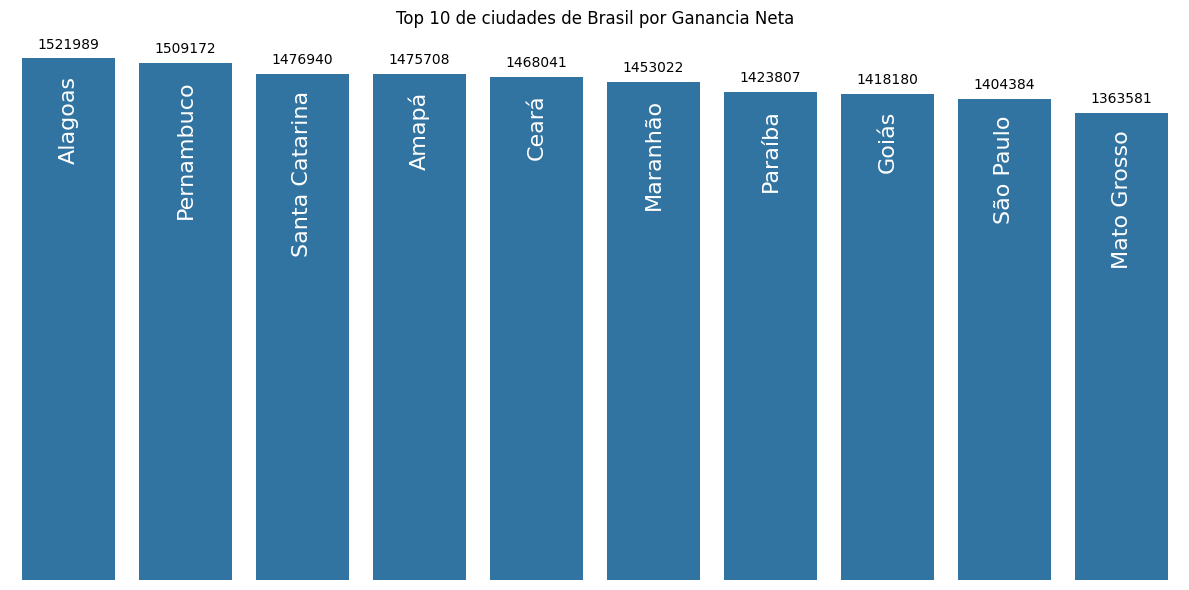

In [53]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=df_top_10_ciudad.ciudad, y=df_top_10_ciudad.ganancia_neta)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

for index, row in df_top_10_ciudad.iterrows():
    ax.text(row.name, row['ganancia_neta']-.5e5, row['ciudad'],
            color='white', ha="center", va='top', rotation=90,fontsize=16)

plt.title('Top 10 de ciudades de Brasil por Ganancia Neta')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.show()

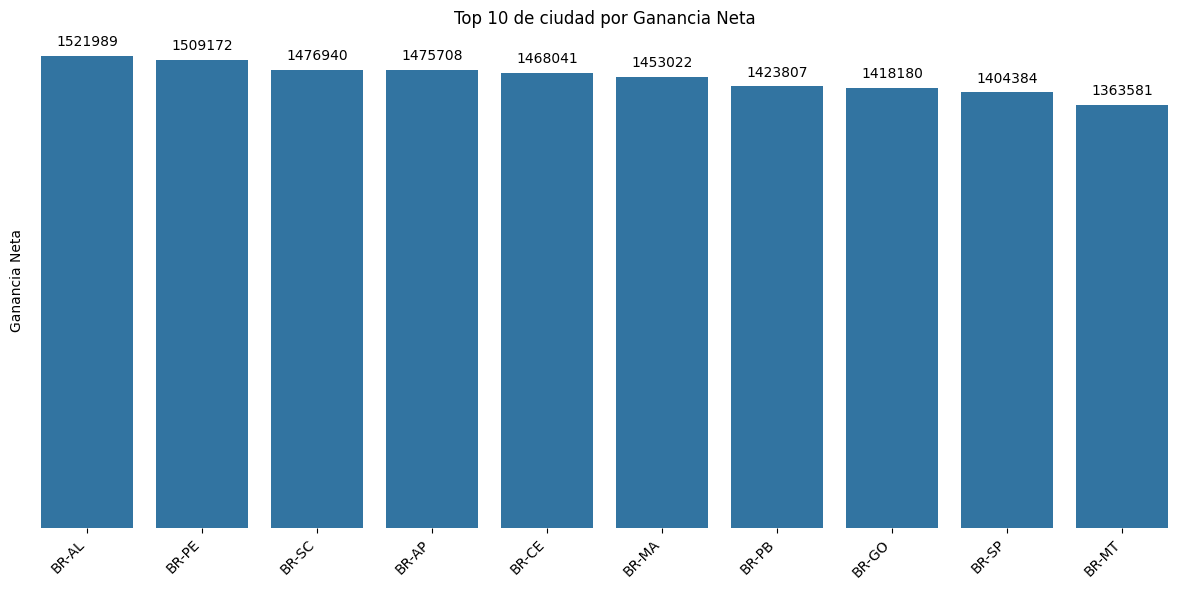

In [54]:
df=df_itens_pedidos.copy()
top_10_ciudad = df.groupby('ciudad')['ganancia_neta'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_10_ciudad.index, y=top_10_ciudad.values)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# for index, row in df_ver.iterrows():
#     ax.text(row.name, row['ganancia_neta']-.5e5, row['marca'],
#             color='white', ha="center", va='top', rotation=90)

plt.title('Top 10 de ciudad por Ganancia Neta')
plt.xlabel('')
plt.ylabel('Ganancia Neta')
plt.xticks(rotation=45, ha='right')
plt.yticks([])
plt.tight_layout()
plt.box(None)
plt.show()

#**3. Preguntas y respuestas**


---




##**3.1 Creando el banco de datos**

In [55]:
#@title
def crear_conexion():
    global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database
    # Crea el engine de SQLite
    # database = 'mi_base_de_datos.db'
    database = create_engine(f'sqlite:///:memory', echo=False)

    # Adiciona los dataframes a las tablas SQL
    df_itens_pedidos.to_sql('itens_pedidos', database, if_exists='replace', index=False)
    df_pedidos.to_sql('pedidos', database, if_exists='replace', index=False)
    df_productos.to_sql('productos', database, if_exists='replace', index=False)
    df_vendedores.to_sql('vendedores', database, if_exists='replace', index=False)

    print("¡Conexión creada y datos guardados en la base de datos!")

# Llama a la función para crear la conexión y guardar los datos
crear_conexion()

¡Conexión creada y datos guardados en la base de datos!


In [56]:
from sqlalchemy import inspect
# engine = create_engine(f'sqlite:///{database}', echo=False)

# Crear el objeto Inspector
inspector = inspect(database)

# Imprimir las tablas en la base de datos
print('Tablas: ', inspector.get_table_names(), '\n')

# Imprimir las columnas de la tabla "pedidos"
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column['name'])


Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
pedido_id
producto_id
vendedor_id
fecha_compra
total


In [57]:
crear_conexion()
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
print('----------------------------------------------')
for column in inspector.get_columns('itens_pedidos'):
    print('Columnas de Tabla itens_pedidos:')
    print(column)
print('----------------------------------------------')
for column in inspector.get_columns('pedidos'):
    print('Columnas de Tabla Pedidos:')
    print(column)
print('----------------------------------------------')
for column in inspector.get_columns('productos'):
    print('Columnas de Tabla productos:')
    print(column)
print('----------------------------------------------')
for column in inspector.get_columns('vendedores'):
    print('Columnas de Tabla vendedores:')
    print(column)
database.dispose()

¡Conexión creada y datos guardados en la base de datos!
Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
----------------------------------------------
Columnas de Tabla itens_pedidos:
{'name': 'id_recibo', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'cantidad', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'valor_unitario', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name': 'valor_total', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Columnas de Tabla itens_pedidos:
{'name

##**Pregunta 1: ¿Cual es el Top 5 productos más vendidos históricamente?**

In [58]:
query_1 = """
SELECT
    productos.producto_id,
    productos.producto,
    productos.marca,
    productos.precio * SUM(itens_pedidos.cantidad) AS total_vendido,
    SUM(itens_pedidos.cantidad) AS cantidad_vendida
FROM
    productos
JOIN
    itens_pedidos ON productos.producto_id = itens_pedidos.producto_id
GROUP BY
    productos.producto_id
ORDER BY
    cantidad_vendida DESC
LIMIT 5;
"""

df_query_1 = pd.read_sql_query(query_1, database)
database.dispose()
df_query_1['total_vendido_K']=(df_query_1['total_vendido']/1000).astype(int)
df_query_1

,producto_id,producto,marca,total_vendido,cantidad_vendida,total_vendido_K
0,32126,Saia Midi Cinto,Limone By Jade Seba,115290.0,549,115
1,13814,Vestido Nude Reta,Ellus,300850.0,547,300
2,47405,Blusa Manga Estampa,Animale,166160.0,536,166
3,33976,Camisa Xadrez Azul,Hollister,61320.0,511,61
4,53941,Cropped Escritas Pb,Linda de Morrer,142240.0,508,142


In [59]:
df_query_1.producto.unique()

array(['Saia Midi Cinto', 'Vestido Nude Reta', 'Blusa Manga Estampa',
       'Camisa Xadrez Azul', 'Cropped Escritas Pb'], dtype=object)

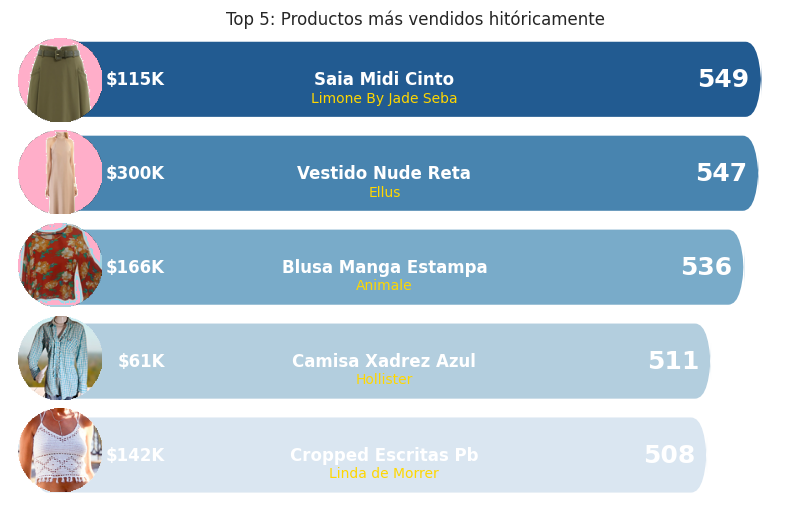

In [60]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import FancyBboxPatch

df=df_query_1.copy()

sns.set(style="whitegrid")
sns.set_palette("Blues_r")

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cantidad_vendida', y='producto', data=df, errorbar=None, hue='producto',palette='Blues_r')

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width()-10, p.get_y() + p.get_height() / 2), ha='right', va='center', xytext=(1, 0), textcoords='offset points',color='white',fontweight='bold',fontsize=18)

for index, value in enumerate(df['total_vendido_K']):
    ax.text(100, index, f'${value}K', va='center', ha='right', color='white',fontweight='bold')

medio=(df.cantidad_vendida.mean())/2
for index, value in enumerate(df['producto']):
    ax.text(medio, index, value, va='center', ha='center', color='white',fontweight='bold')

medio=(df.cantidad_vendida.mean())/2
for index, value in enumerate(df['marca']):
    ax.text(medio, index+.2, value, va='center', ha='center', color='gold',fontsize=10)


plt.title('Top 5: Productos más vendidos hitóricamente')

#Redondeo de barras:
new_patches = []
for patch in reversed(ax.patches):
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=12",
                            ec="none", fc=color,
                            mutation_aspect=0.05
                            )
    patch.remove()
    new_patches.append(p_bbox)

for patch in new_patches:
    ax.add_patch(patch)


img_path_01 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/falda_midi_cinto_r.png'
img_path_02 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/Vestido_recto_nude_r.png'
img_path_03 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/blusa_mangas_estampadas_r.png'
img_path_04 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/camisa_xadrez_azul_r.png'
img_path_05 = '/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/img/cropped_escritas_r.png'
img_list=[img_path_05,img_path_04,img_path_03,img_path_02,img_path_01]
#Colocar img:
for i, patch in enumerate(ax.patches):
    img = OffsetImage(plt.imread(img_list[i]), zoom=.6)
    ab = AnnotationBbox(img, (patch.get_x()+10, patch.get_y()+.01 + patch.get_height() / 2), frameon=False, xycoords='data', boxcoords="offset points", pad=0.5)
    ax.add_artist(ab)

sns.despine(left=True, bottom=True)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.box(None)
plt.show()

##**1.2 Visualización:**

##**Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

In [61]:
query_2='''
SELECT
    pedidos.fecha_compra,
    SUM(pedidos.total - itens_pedidos.costo_envio) AS total_ventas
FROM
    pedidos
JOIN
    itens_pedidos itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
GROUP BY
    pedidos.fecha_compra;
'''
df_query_2 = pd.read_sql_query(query_2, database)
database.dispose()
df_query_2

,fecha_compra,total_ventas
0,2019-01-05 00:00:00.000000,32460.8
1,2019-01-06 00:00:00.000000,1728.0
2,2019-01-07 00:00:00.000000,1560.0
3,2019-01-08 00:00:00.000000,1024.0
4,2019-01-09 00:00:00.000000,400.0
...,...,...
775,2021-02-21 00:00:00.000000,30944.8
776,2021-03-07 00:00:00.000000,4744.0
777,2021-03-08 00:00:00.000000,16206.4
778,2021-03-09 00:00:00.000000,4128.0


In [62]:
query_2_1='''
SELECT
    pedidos.*,
    itens_pedidos.*,
    productos.*,
    SUM(pedidos.total - itens_pedidos.costo_envio) AS total_ventas
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
GROUP BY
    pedidos.fecha_compra;
'''
df_query_2_1 = pd.read_sql_query(query_2_1, database)
database.dispose()
df_query_2_1

,pedido_id,producto_id,vendedor_id,fecha_compra,total,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,...,ciudad,costo_envio,ganancia_neta,producto_id,producto,precio,marca,sku,condicion,total_ventas
0,341,41518,6,2019-01-05 00:00:00.000000,780,1,41518,341,3,260,...,BR-BA,156.0,624,41518,Calca Jeans Basica,260.0,Banana Republic,255410.0,Nuevo con etiqueta,32460.8
1,3687,100961,3,2019-01-06 00:00:00.000000,960,10,100961,3687,2,480,...,BR-GO,192.0,768,100961,Vestido Preto Renda,480.0,Dress&co,175945.0,Usado,1728.0
2,3870,59337,3,2019-01-07 00:00:00.000000,1950,12,59337,3870,5,390,...,BR-CE,390.0,1560,59337,Blusa Tricot Mescla,390.0,Levi's,295977.0,Usado,1560.0
3,4004,79079,5,2019-01-08 00:00:00.000000,1280,13,79079,4004,4,320,...,BR-RS,256.0,1024,79079,Regata Nude Textura,320.0,Gregory,247347.0,Usado,1024.0
4,4471,27336,2,2019-01-09 00:00:00.000000,500,14,27336,4471,2,250,...,BR-AC,100.0,400,27336,Calca Preta Resinada,250.0,Ellus,122068.0,Usado,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,37393,28699,4,2021-02-21 00:00:00.000000,2100,25012,28699,37393,5,420,...,BR-PR,420.0,1680,28699,Calca Verde Bolsos,420.0,Brooksfield,947048.0,Usado,30944.8
776,55724,100961,1,2021-03-07 00:00:00.000000,1440,25039,100961,55724,3,480,...,BR-MT,288.0,1152,100961,Vestido Preto Renda,480.0,Dress&co,175945.0,Usado,4744.0
777,59966,39368,1,2021-03-08 00:00:00.000000,558,25045,39368,59966,2,279,...,BR-SP,111.6,446,39368,Shorts Neoprene Pb,279.0,Animale,305188.0,Usado,16206.4
778,63716,64127,1,2021-03-09 00:00:00.000000,2360,25051,64127,63716,4,590,...,BR-PE,472.0,1888,64127,Vestido Textura Branco,590.0,J. Crew,317928.0,Usado,4128.0


In [63]:
query_2_11='''
SELECT
    pedidos.*,
    itens_pedidos.*,
    productos.*
FROM
    pedidos
JOIN
    itens_pedidos ON pedidos.pedido_id = itens_pedidos.pedido_id
JOIN
    productos ON itens_pedidos.producto_id = productos.producto_id
GROUP BY
    pedidos.pedido_id;
'''
df_query_2_11 = pd.read_sql_query(query_2_11, database)
database.dispose()
df_query_2_11

,pedido_id,producto_id,vendedor_id,fecha_compra,total,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio,ganancia_neta,producto_id,producto,precio,marca,sku,condicion
0,1,5292,2,2020-02-16 00:00:00.000000,3456,10062,5292,1,6,576,3456,BR-PE,691.2,2764,5292,Saia Jeans Forest,576.0,Mixed,222683.0,Nuevo con etiqueta
1,3,29650,3,2020-02-01 00:00:00.000000,720,9453,29650,3,6,120,720,BR-CE,144.0,576,29650,Vestido Estampa Pb,120.0,H&m,285576.0,Usado
2,9,18751,5,2021-02-04 00:00:00.000000,5940,24512,18751,9,6,990,5940,BR-SC,1188.0,4752,18751,Vestido Couro Franjas,990.0,Spezzato,304187.0,Nuevo con etiqueta
3,11,7871,3,2019-12-01 00:00:00.000000,2520,7184,7871,11,6,420,2520,BR-DF,504.0,2016,7871,Vestido Ziper Fendi,420.0,Thelure,318544.0,Usado
4,21,2706,3,2020-01-03 00:00:00.000000,2950,8221,2706,21,5,590,2950,BR-MT,590.0,2360,2706,Blusa Cinza,590.0,Mixed,297627.0,Usado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24522,139961,27546,4,2020-10-25 00:00:00.000000,336,19768,27546,139961,1,336,336,BR-PI,67.2,268,27546,Calca Veludo Cotele,336.0,Joe's,236203.0,Usado
24523,139962,20029,3,2019-11-27 00:00:00.000000,1176,6974,20029,139962,4,294,1176,BR-MA,235.2,940,20029,Tenis Xadrez Tecido,294.0,Converse,121965.0,Usado
24524,139964,25562,5,2020-01-22 00:00:00.000000,640,9044,25562,139964,2,320,640,BR-SC,128.0,512,25562,Calca Jeans Reta,320.0,Miss Sixty,263656.0,Usado
24525,139980,48872,4,2020-04-18 00:00:00.000000,120,12647,48872,139980,1,120,120,BR-ES,24.0,96,48872,Choker Pedra Branca,120.0,Fabiana Caterina,274593.0,Nuevo con etiqueta


In [64]:
# 2019-11-24 00:00:00.000000
df_time_max_value=df_query_2_11[df_query_2_11.fecha_compra=='2019-11-24 00:00:00.000000']
df_time_max_value.head(5)

,pedido_id,producto_id,vendedor_id,fecha_compra,total,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio,ganancia_neta,producto_id,producto,precio,marca,sku,condicion
22,138,5412,3,2019-11-24 00:00:00.000000,788,6555,5412,138,1,788,788,BR-SP,157.6,630,5412,Camiseta Tencel Umay,788.0,Mixed,257373.0,Nuevo con etiqueta
138,854,87156,4,2019-11-24 00:00:00.000000,800,6556,87156,854,5,160,800,BR-AL,160.0,640,87156,Vestido Floral Laco,160.0,Sweet Cotton,263312.0,Usado
363,2138,13472,4,2019-11-24 00:00:00.000000,2250,6557,13472,2138,5,450,2250,BR-GO,450.0,1800,13472,Peeptoe Preto Verniz,450.0,Jorge Bischoff,318875.0,Usado
451,2565,73692,1,2019-11-24 00:00:00.000000,90,6558,73692,2565,1,90,90,BR-SP,18.0,72,73692,Shorts Estampa Floral,90.0,Zara,238011.0,Usado
524,2936,83009,5,2019-11-24 00:00:00.000000,1400,6559,83009,2936,5,280,1400,BR-RN,280.0,1120,83009,Body Babado Pb,280.0,Karmani,263899.0,Usado


In [65]:
# Vestido Longo Preto
df_time_max_value[df_time_max_value.producto=='Vestido Longo Preto']

,pedido_id,producto_id,vendedor_id,fecha_compra,total,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio,ganancia_neta,producto_id,producto,precio,marca,sku,condicion
7763,43999,89100,1,2019-11-24 00:00:00.000000,25200,6614,89100,43999,6,4200,25200,BR-PR,5040.0,20160,89100,Vestido Longo Preto,4200.0,Barbara Bela,104978.0,Usado


In [66]:
marca_ganancias_max_time=df_time_max_value.groupby('marca')['ganancia_neta'].sum()
df_marca_ganancias_max_time=pd.DataFrame(marca_ganancias_max_time)
df_marca_ganancias_max_time.sort_values(by='ganancia_neta',inplace=True,ascending=False)
df_marca_ganancias_max_time

,ganancia_neta
marca,
Barbara Bela,20160
Givenchy,19200
Mixed,18681
Tory Burch,13904
Jimmy Choo,12432
...,...
Forever 21,208
Erre Erre,192
Limone By Jade Seba,168


In [67]:
marca_producto_ganancias_max_time=df_time_max_value.groupby(['marca','producto','cantidad'])['ganancia_neta'].sum()
df_marca_producto_ganancias_max_time=pd.DataFrame(marca_producto_ganancias_max_time)
df_marca_producto_ganancias_max_time.sort_values(by='ganancia_neta',inplace=True,ascending=False)
df_marca_producto_ganancias_max_time.reset_index(drop=False,inplace=True)
df_marca_producto_ganancias_max_time['porcetajes']=df_marca_producto_ganancias_max_time.ganancia_neta*100/df_marca_producto_ganancias_max_time.ganancia_neta.sum()
df_marca_producto_ganancias_max_time

,marca,producto,cantidad,ganancia_neta,porcetajes
0,Barbara Bela,Vestido Longo Preto,6,20160,6.952779
1,Givenchy,Bolsa Coral Saco,6,19200,6.621694
2,Jimmy Choo,Scarpin Bege Textura,6,12432,4.287547
3,D&g Dolce & Gabbana,Oculos Lente Azulada,5,8960,3.090124
4,Kate Spade,Vestido Amarelo Laco,6,6720,2.317593
...,...,...,...,...,...
187,H&m,Vestido Estampa Pb,1,96,0.033108
188,Zara,Blusa Preta Aplicacao,1,88,0.030349
189,Zara,Saia Pregas Preta,1,72,0.024831
190,Zara,Shorts Estampa Floral,1,72,0.024831


In [68]:
marca_producto_ganancias_max_time = df_time_max_value.groupby(['marca', 'producto'])['ganancia_neta'].sum().reset_index()
marca_ganancia_total = marca_producto_ganancias_max_time.groupby('marca')['ganancia_neta'].sum().reset_index()
marca_ganancia_total = marca_ganancia_total.sort_values(by='ganancia_neta', ascending=False)

# Reordenar el DataFrame de marca_producto_ganancias_max_time
marca_producto_ganancias_max_time = marca_producto_ganancias_max_time.merge(marca_ganancia_total, on='marca', suffixes=('', '_total'))
marca_producto_ganancias_max_time = marca_producto_ganancias_max_time.sort_values(by='ganancia_neta_total', ascending=False)

# Verificar el resultado
marca_producto_ganancias_max_time.head(20)


,marca,producto,ganancia_neta,ganancia_neta_total
15,Barbara Bela,Vestido Longo Preto,20160,20160
49,Givenchy,Bolsa Coral Saco,19200,19200
82,Mixed,Blusa Cinza,2360,18681
83,Mixed,Calca Linho Ten,1592,18681
84,Mixed,Camisa Seda Pb,1276,18681
85,Mixed,Camiseta Cindy Sky,3281,18681
86,Mixed,Camiseta Eternity,2576,18681
87,Mixed,Camiseta Tencel Umay,630,18681
88,Mixed,Casaqueto Fio Mescla,1896,18681
89,Mixed,Saia Guipir Nude,2960,18681


<ipython-input-69-34e4f1f84ee5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc['Otros'] = otros


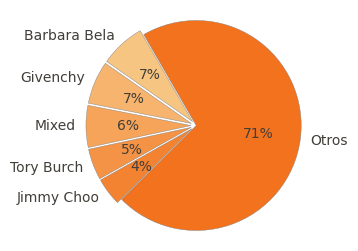

In [69]:
df=df_marca_ganancias_max_time.copy()

# Obtener las marcas que superan el 4% y sumar los porcentajes del resto
df_filtered = df[df['ganancia_neta'] > df['ganancia_neta'].sum() * 0.04]
otros = df[df['ganancia_neta'] <= df['ganancia_neta'].sum() * 0.04]['ganancia_neta'].sum()
df_filtered.loc['Otros'] = otros

# Crear el gráfico de pastel
plt.figure(figsize=(3, 3),facecolor='none')
# plt.title('Distribución de ganancias por marca')

# Utilizar colores predeterminados de Seaborn
colors = sns.color_palette("blend:#F7C582,#F2721D", len(df_filtered))
explode = [0.05,.05,.05,.05,.05,0]
wedgeprops = {'edgecolor': 'gray', 'linewidth': .3}
text_props = {'color': '#423E39', 'fontsize': 10}
plt.pie(df_filtered['ganancia_neta'],explode=explode, labels=df_filtered.index, colors=colors, autopct='%1.0f%%', startangle=120,textprops=text_props,wedgeprops=wedgeprops)

# Mostrar el gráfico
plt.axis('equal')  # Asegurar que el gráfico de pastel sea circular
plt.savefig('/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/grafica_metrics_unique.png', dpi=100, bbox_inches='tight')

plt.show()


In [70]:
df_time_max_value.marca.value_counts()

marca
Zara             20
Mixed            14
Le Lis Blanc      7
Animale           7
Farm              7
                 ..
Cris Barros       1
Dkny              1
Mara Mac          1
Louis Vuitton     1
Erre Erre         1
Name: count, Length: 86, dtype: int64

In [71]:
df_time_max_value['ganancia_neta']=df_time_max_value.valor_total-df_time_max_value.costo_envio
df_time_max_value['ganancia_neta'].sum()

<ipython-input-71-d544bd145a30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_max_value['ganancia_neta']=df_time_max_value.valor_total-df_time_max_value.costo_envio


289960.80000000005

In [72]:
df_query_2_1[df_query_2_1.index==df_query_2_1['total_ventas'].idxmax()]

,pedido_id,producto_id,vendedor_id,fecha_compra,total,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,...,ciudad,costo_envio,ganancia_neta,producto_id,producto,precio,marca,sku,condicion,total_ventas
323,133120,17258,2,2019-11-24 00:00:00.000000,2100,6542,17258,133120,5,420,...,BR-PR,420.0,1680,17258,Saia Transparente Cover,420.0,Luisa Farani,257900.0,Usado,289960.8


In [73]:
max_row = df_query_2_1.loc[df_query_2_1['total_ventas'].idxmax()]
df_max_row=pd.DataFrame(max_row)
df_max_row

,323
pedido_id,133120
producto_id,17258
vendedor_id,2
fecha_compra,2019-11-24 00:00:00.000000
total,2100
id_recibo,6542
producto_id,17258
pedido_id,133120
cantidad,5
valor_unitario,420


In [74]:
df = df_query_2.copy()

df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

df['año_mes'] = df['fecha_compra'].dt.to_period('M')
df

,fecha_compra,total_ventas,año_mes
0,2019-01-05,32460.8,2019-01
1,2019-01-06,1728.0,2019-01
2,2019-01-07,1560.0,2019-01
3,2019-01-08,1024.0,2019-01
4,2019-01-09,400.0,2019-01
...,...,...,...
775,2021-02-21,30944.8,2021-02
776,2021-03-07,4744.0,2021-03
777,2021-03-08,16206.4,2021-03
778,2021-03-09,4128.0,2021-03


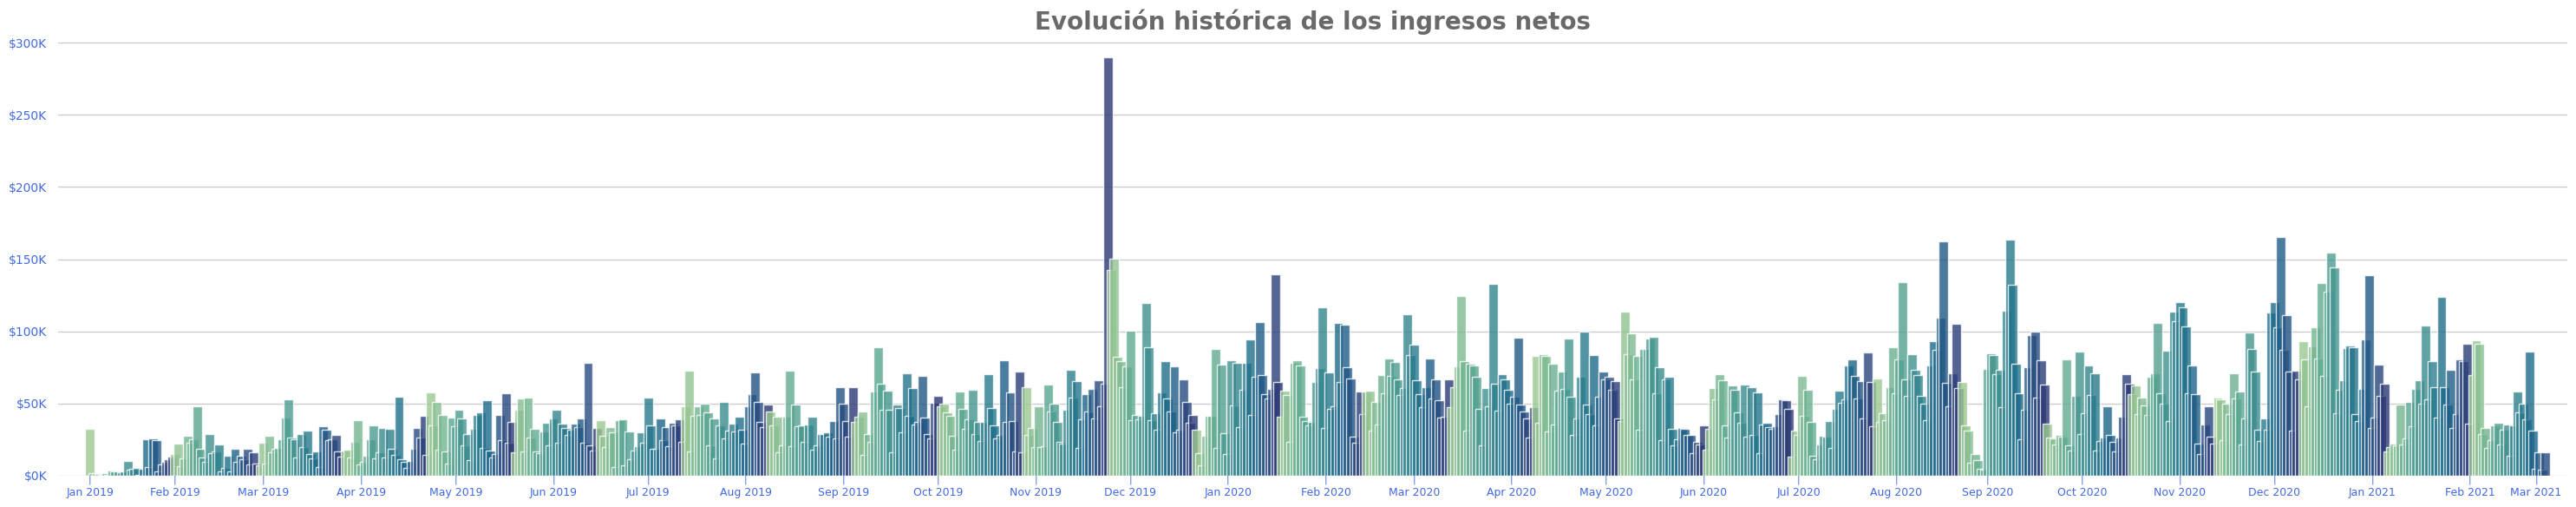

In [75]:
from matplotlib.transforms import Bbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

df = df_query_2.copy()

# Convertir la columna de fecha a tipo datetime
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Obtener la columna de año y mes como una cadena de texto
df['año_mes'] = df['fecha_compra'].dt.strftime('%b %Y')

plt.figure(figsize=(30, 6))

# Obtener las etiquetas únicas de año-mes
unique_labels = df['año_mes'].unique()
index = list(range(len(df)))

# Obtener los índices enteros para las etiquetas únicas de año-mes
index_labels = [df[df['año_mes'] == label].index.min() for label in unique_labels]

# Especificar la paleta de colores
palette = sns.color_palette("crest", len(unique_labels))
bar_width=3
plt.bar(index, df['total_ventas'], bar_width, color=palette, alpha=0.8)

# Definir la posición y las etiquetas del eje x
plt.xticks(index_labels, unique_labels, rotation=0, ha='center', fontsize=9, color='royalblue')

# Agregar | a los xticks:
for i, label in enumerate(unique_labels[:-1]):
    # print(index_labels[i])
    plt.annotate('|', xy=(index_labels[i], 0), xytext=(index_labels[i+1], 0), ha='center', va='top', fontsize=8, color='royalblue')
plt.annotate('|', xy=(0, 0), xytext=(0, 0), ha='center', va='top', fontsize=8, color='royalblue')

plt.xlabel('')
plt.ylabel('')
plt.title('Evolución histórica de los ingresos netos',fontsize=20,fontweight='bold', color='dimgray')
plt.grid(axis='x')
plt.tight_layout()
plt.xlim(index_labels[0]-10, index_labels[-1]+10)

# Dar formato a las etiquetas del eje y
formatter = FuncFormatter(lambda x, _: f'${int(x/1000)}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.yticks(fontsize=10,color='royalblue')
plt.box(None)

# Añadir la imagen graf pie (% cumulado)
img_pie='/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/grafica_metrics_unique.png'
img_ventas = OffsetImage(plt.imread(img_pie), zoom=.7)
ab_ventas = AnnotationBbox(img_ventas, (269, 250000), frameon=False, xycoords='axes fraction', boxcoords='axes fraction', pad=0, zorder=100)
ax.add_artist(ab_ventas)

plt.show()


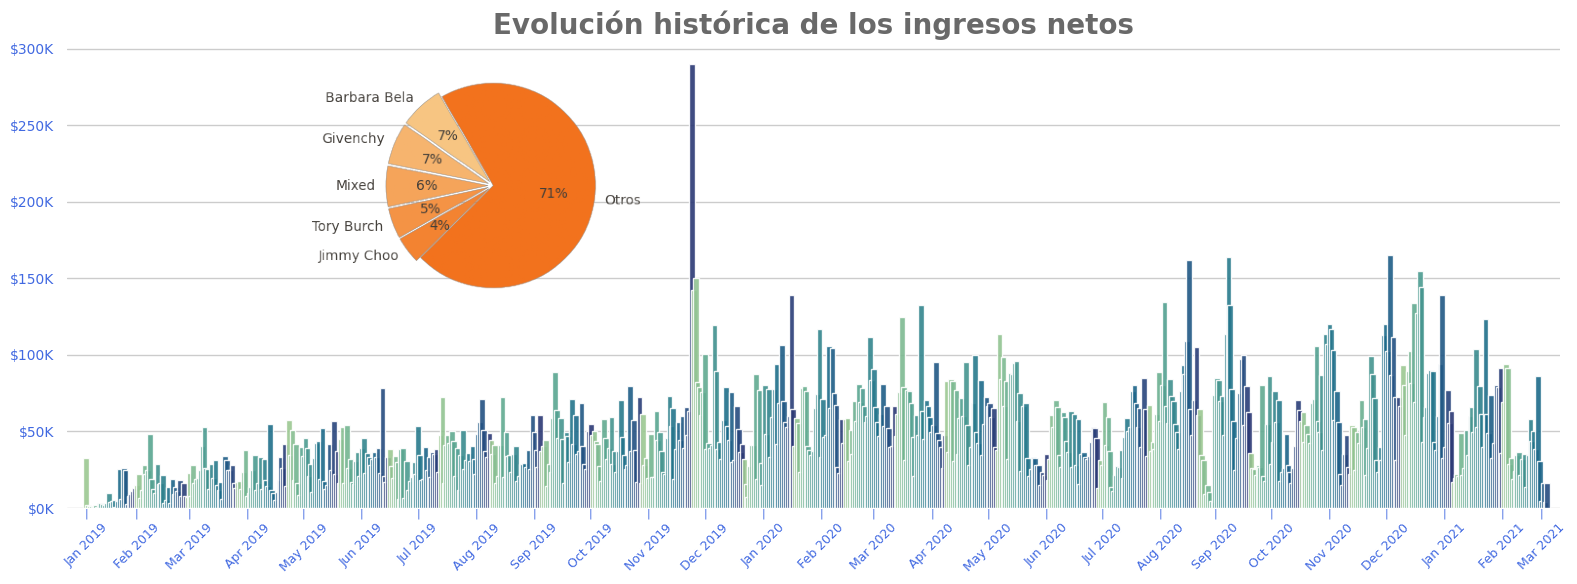

In [76]:
from matplotlib.transforms import Bbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

df = df_query_2.copy()

# Convertir la columna de fecha a tipo datetime
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Obtener la columna de año y mes como una cadena de texto
df['año_mes'] = df['fecha_compra'].dt.strftime('%b %Y')

plt.figure(figsize=(16, 6))
ax = plt.gca()  # Obtener el objeto de ejes

# Obtener las etiquetas únicas de año-mes
unique_labels = df['año_mes'].unique()
index = list(range(len(df)))

# Obtener los índices enteros para las etiquetas únicas de año-mes
index_labels = [df[df['año_mes'] == label].index.min() for label in unique_labels]

# Especificar la paleta de colores
palette = sns.color_palette("crest", len(unique_labels))
bar_width=3
plt.bar(index, df['total_ventas'], bar_width, color=palette, alpha=0.9)

# Definir la posición y las etiquetas del eje x
plt.xticks(index_labels, unique_labels, rotation=45, ha='center', fontsize=9, color='royalblue')

# Agregar | a los xticks:
for i, label in enumerate(unique_labels[:-1]):
    # print(index_labels[i])
    plt.annotate('|', xy=(index_labels[i], 0), xytext=(index_labels[i+1], 0), ha='center', va='top', fontsize=8, color='royalblue')
plt.annotate('|', xy=(0, 0), xytext=(0, 0), ha='center', va='top', fontsize=8, color='royalblue')

plt.xlabel('')
plt.ylabel('')
plt.title('Evolución histórica de los ingresos netos',fontsize=20,fontweight='bold', color='dimgray')
plt.grid(axis='x')
plt.tight_layout()
plt.xlim(index_labels[0]-10, index_labels[-1]+10)

# Dar formato a las etiquetas del eje y
formatter = FuncFormatter(lambda x, _: f'${int(x/1000)}K')
plt.gca().yaxis.set_major_formatter(formatter)
plt.yticks(fontsize=10,color='royalblue')
plt.box(None)

# Añadir la imagen graf pie (% cumulado)
img_pie='/content/drive/MyDrive/Bootcamp-Alejo-projects/Store Sales Analysis/graf/grafica_metrics_unique.png'
img_ventas = OffsetImage(plt.imread(img_pie), zoom=.7)  # Ajusta el zoom según sea necesario
ab_ventas = AnnotationBbox(img_ventas, (index_labels[7], 210000), frameon=False, xycoords='data', boxcoords='data', pad=0, zorder=100)  # Ajusta las coordenadas según sea necesario
ax.add_artist(ab_ventas)

plt.show()


In [77]:
df_query_2.total_ventas.max()

289960.8

In [78]:
fila_maxima = df_query_2.loc[df_query_2['total_ventas'].idxmax()]
fila_maxima

fecha_compra    2019-11-24 00:00:00.000000
total_ventas                      289960.8
Name: 323, dtype: object

##**Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

In [79]:
query_3='''
SELECT
    v.nombre_vendedor,
    SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2019' THEN p.total - ip.costo_envio ELSE 0 END) AS "Año 2019",
    SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2020' THEN p.total - ip.costo_envio ELSE 0 END) AS "Año 2020",
    SUM(CASE WHEN strftime('%Y', p.fecha_compra) = '2021' THEN p.total - ip.costo_envio ELSE 0 END) AS "Año 2021"
FROM
    pedidos p
JOIN
    vendedores v ON p.vendedor_id = v.vendedor_id
JOIN
    itens_pedidos ip ON p.pedido_id = ip.pedido_id
GROUP BY
    v.nombre_vendedor;
'''
df_query_3 = pd.read_sql_query(query_3, database)
database.dispose()
df_query_3

,nombre_vendedor,Año 2019,Año 2020,Año 2021
0,Ana Duarte,2154261.6,5054009.6,547470.4
1,Daniel Siqueira,2020503.2,5266932.8,419702.4
2,Millena Pereira,2054682.4,3804385.6,398896.0
3,Nadia Oliveira,2296986.4,4046902.4,810020.0
4,Paulo Calanca,3702835.2,3609530.4,455401.6


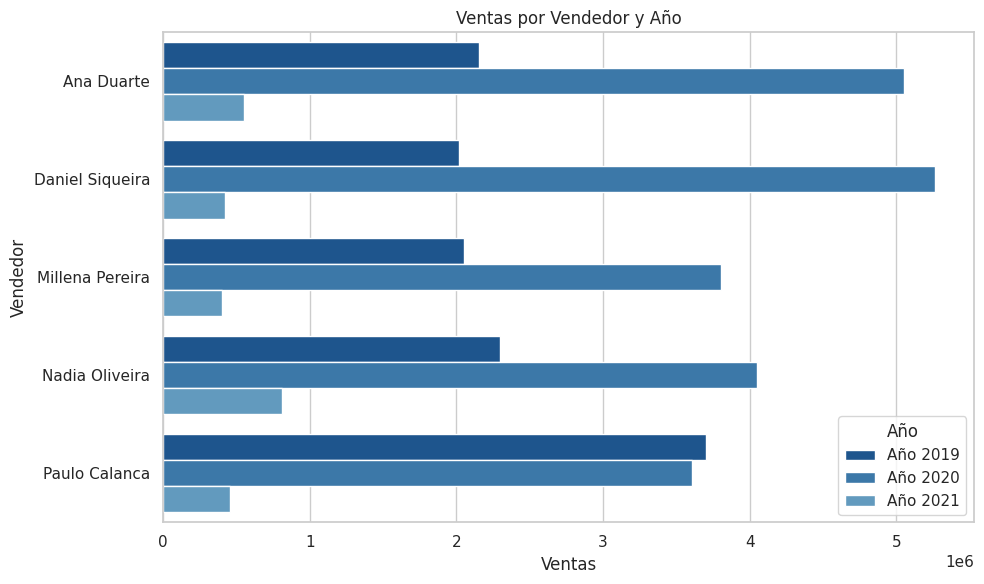

In [80]:
df = df_query_3.copy()

df_melted = df.melt(id_vars='nombre_vendedor', var_name='Año', value_name='Ventas')

# Crear el gráfico de barras apiladas horizontales
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Ventas', y='nombre_vendedor', hue='Año', orient='horizontal')

# Etiquetas y título
plt.xlabel('Ventas')
plt.ylabel('Vendedor')
plt.title('Ventas por Vendedor y Año')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

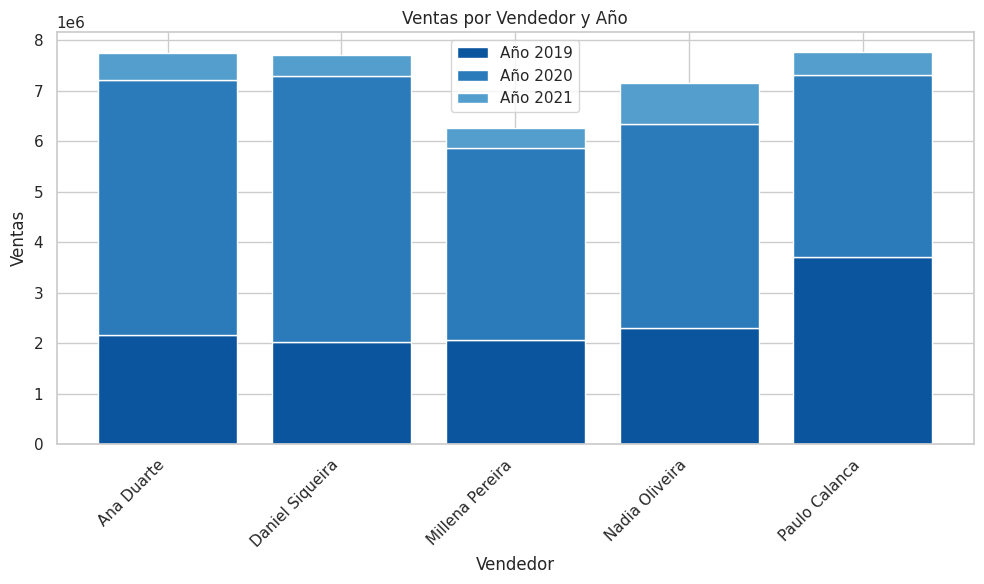

In [81]:
df = df_query_3.copy()

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
plt.bar(df['nombre_vendedor'], df['Año 2019'], label='Año 2019')
plt.bar(df['nombre_vendedor'], df['Año 2020'], bottom=df['Año 2019'], label='Año 2020')
plt.bar(df['nombre_vendedor'], df['Año 2021'], bottom=df['Año 2019'] + df['Año 2020'], label='Año 2021')

# Etiquetas y título
plt.xlabel('Vendedor')
plt.ylabel('Ventas')
plt.title('Ventas por Vendedor y Año')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


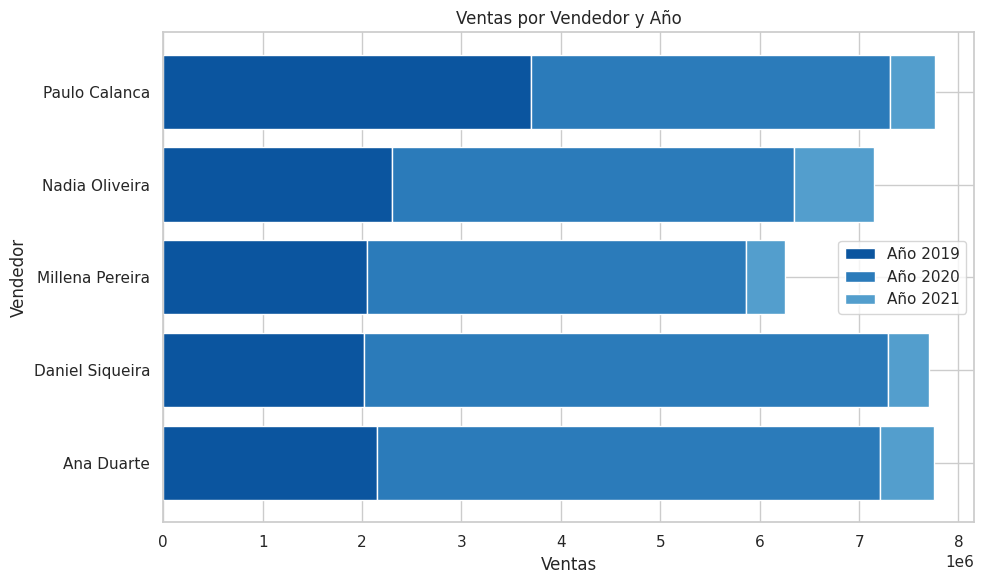

In [82]:
df = df_query_3.copy()

# Crear el gráfico de barras horizontales apiladas
plt.figure(figsize=(10, 6))

# Barra para el año 2019
plt.barh(df['nombre_vendedor'], df['Año 2019'], label='Año 2019')

# Barra para el año 2020, colocada sobre la de 2019
plt.barh(df['nombre_vendedor'], df['Año 2020'], left=df['Año 2019'], label='Año 2020')

# Barra para el año 2021, colocada sobre las de 2019 y 2020
plt.barh(df['nombre_vendedor'], df['Año 2021'], left=df['Año 2019'] + df['Año 2020'], label='Año 2021')

# Etiquetas y título
plt.xlabel('Ventas')
plt.ylabel('Vendedor')
plt.title('Ventas por Vendedor y Año')

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


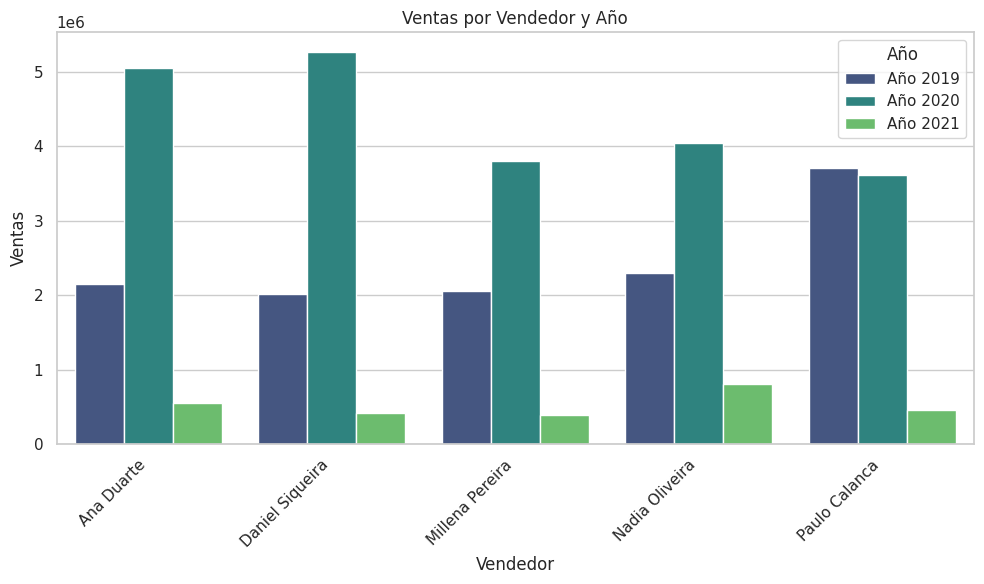

In [83]:
df = df_query_3.copy()

# Melt para convertir los datos a formato largo
df_melted = df.melt(id_vars='nombre_vendedor', var_name='Año', value_name='Ventas')

# Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='nombre_vendedor', y='Ventas', hue='Año', palette='viridis')

# Etiquetas y título
plt.xlabel('Vendedor')
plt.ylabel('Ventas')
plt.title('Ventas por Vendedor y Año')

# Mostrar el gráfico
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


##**Pregunta 4: ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

In [84]:
query_4='''
SELECT
    ip.ciudad,
    REPLACE(ip.ciudad, 'BR-', '') AS abbrev_state,
    SUM(p.total - ip.costo_envio) AS ingresos_netos
FROM
    pedidos p
JOIN
    itens_pedidos ip ON p.pedido_id = ip.pedido_id
GROUP BY
    ip.ciudad;
'''
df = pd.read_sql_query(query_4, database)
database.dispose()
df

,ciudad,abbrev_state,ingresos_netos
0,BR-AC,AC,1128520.0
1,BR-AL,AL,1522016.0
2,BR-AM,AM,1244092.8
3,BR-AP,AP,1475737.6
4,BR-BA,BA,1322517.6
5,BR-CE,CE,1468080.8
6,BR-DF,DF,1327094.4
7,BR-ES,ES,1275874.4
8,BR-GO,GO,1418205.6
9,BR-MA,MA,1453059.2


In [85]:
import geopandas as gpd
import geobr

br_uf = geobr.read_state()
br_uf = br_uf.rename(columns={'abbrev_state': 'abbrev_state'})
br_uf_d = br_uf.merge(df, on='abbrev_state')
br_uf_d = br_uf_d[['geometry','abbrev_state', 'ingresos_netos']]
br_uf_d.head()

,geometry,abbrev_state,ingresos_netos
0,"MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...",RO,1317495.2
1,"MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...",AC,1128520.0
2,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...",AM,1244092.8
3,"MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...",RR,1349770.4
4,"MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...",PA,1345199.2


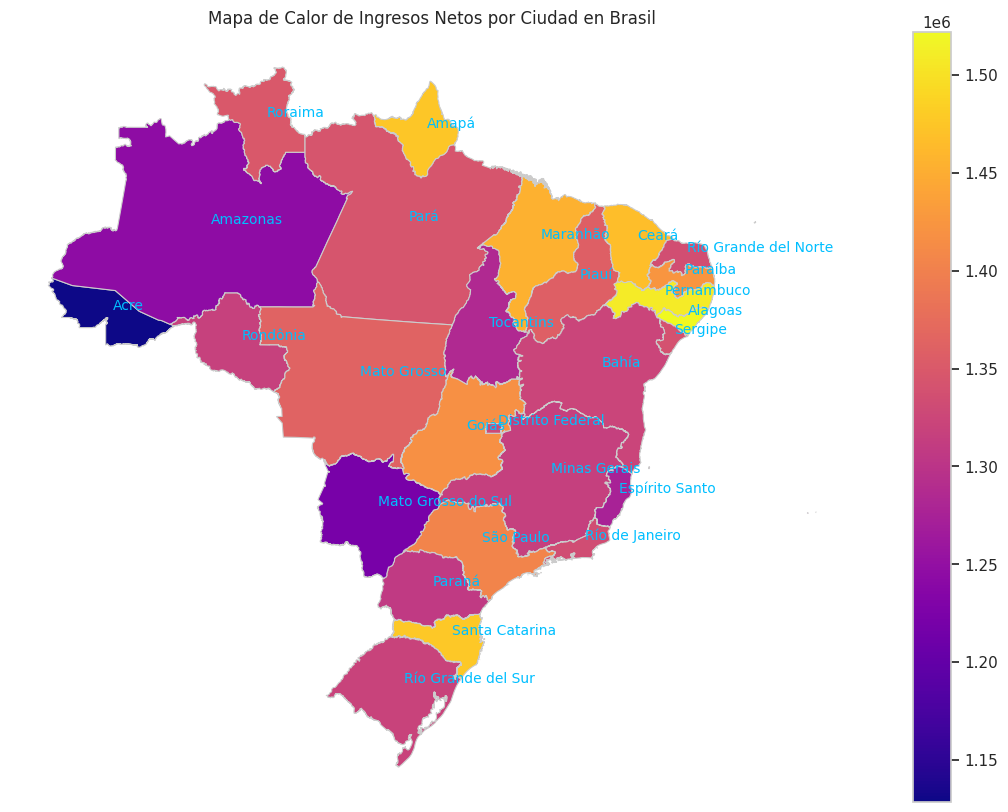

In [86]:
# Diccionario de correspondencias entre siglas y nombres de ciudades
ciudades = {
    'AC': 'Acre',
    'AL': 'Alagoas',
    'AM': 'Amazonas',
    'AP': 'Amapá',
    'BA': 'Bahía',
    'CE': 'Ceará',
    'DF': 'Distrito Federal',
    'ES': 'Espírito Santo',
    'GO': 'Goiás',
    'MA': 'Maranhão',
    'MG': 'Minas Gerais',
    'MS': 'Mato Grosso do Sul',
    'MT': 'Mato Grosso',
    'PA': 'Pará',
    'PB': 'Paraíba',
    'PE': 'Pernambuco',
    'PI': 'Piauí',
    'PR': 'Paraná',
    'RJ': 'Río de Janeiro',
    'RN': 'Río Grande del Norte',
    'RO': 'Rondônia',
    'RR': 'Roraima',
    'RS': 'Río Grande del Sur',
    'SC': 'Santa Catarina',
    'SE': 'Sergipe',
    'SP': 'São Paulo',
    'TO': 'Tocantins'
}

# Reemplazar las siglas por los nombres de las ciudades en el dataframe
br_uf_d['state'] = br_uf_d['abbrev_state'].map(ciudades)

br_uf_d = br_uf_d.to_crs(epsg=3857)

# Crear el mapa de calor con los nombres de las ciudades
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# br_uf_d.plot(column='ingresos_netos', cmap='cividis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True) ###MAPA PARA DALTONICOS
br_uf_d.plot(column='ingresos_netos', cmap='plasma', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# br_uf_d.plot(column='ingresos_netos', cmap='inferno', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# br_uf_d.plot(column='ingresos_netos', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Agregar el nombre de la ciudad en cada lugar
for x, y, label in zip(br_uf_d.geometry.centroid.x, br_uf_d.geometry.centroid.y, br_uf_d.state):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=10, color='deepskyblue')
    # ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=10, color='dodgerblue')

plt.title('Mapa de Calor de Ingresos Netos por Ciudad en Brasil')
plt.axis('off')
plt.show()
